Load the required libraries. 

In [1]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
from os.path import isfile, join
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
import math
from scipy.stats import skew, kurtosis
import functools
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from sklearn.metrics import r2_score
import scipy.stats as st

In [2]:
#load the data
with open('Pandas Pickle Data/cycle_names.pkl', 'rb') as f:
    cycle_names = pickle.load(f)
cycle_data = {}
for name in cycle_names:
    cycle_data[name] = pd.read_pickle('Pandas Pickle Data/' + str(name))

#Loading the metadata
metadata = pd.read_pickle('Pandas Pickle Data/metadata.pkl')

#loading EOL lists
no_EOL = list(metadata[metadata['EOL']==0].index)
EOL = list(metadata[metadata['EOL']!=0].index)

pd.set_option('display.max_columns', None)

# Data Analysis

Read the data and save it as dictionaries for cycle and timeseries data with each cell as key and the corresponding pandas dataframe as values. Also read the metadata.

In [31]:
#reading the file_names from the folder
mypath = 'SNL_Cycle_Timeseries_Data'
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]

#creating new file_names from old ones
new_file_names = []
for i in range(len(file_names)):
    string = file_names[i]
    string = string.replace('SNL_18650_', '')
    string = string.replace('.', '_')
    string = string.replace('-', '_')
    string = string.replace('_csv', '')
    new_file_names.append(string)
    
#separating names of timeseries and cycle_data
cycle_names = []
timeseries_names = []
for i in new_file_names:
    if 'cycle_data' in i:
        cycle_names.append(i)
    else:
        timeseries_names.append(i)
        
#reading the metadata
metadata = pd.read_csv('metadata.csv',  header=0, skiprows=range(1,31))

#creating a dictionary which includes keys as new_file_names and values as pd Dataframe of the file
#a dictionary for cycle and timeseries data
cycle_data = {}
timeseries_data = {}
for name, new_name in zip(file_names, new_file_names):
    if 'cycle_data' in name:
        cycle_data[new_name] = pd.read_csv(filepath_or_buffer=(mypath + '/' + name))
    else:
        timeseries_data[new_name] = pd.read_csv(filepath_or_buffer=(mypath + '/' + name))

Replace missing values in the temperature columns.

In [32]:
#see which dataframes have missing values
df_nan = []
for i in range(len(timeseries_data)):
    if timeseries_data[timeseries_names[i]].isnull().values.any() == True:
        df_nan.append(i)
        
#replacing missing values with their corresponding temperatures
for i in df_nan:
    timeseries_data[timeseries_names[i]] = timeseries_data[timeseries_names[i]].fillna(metadata['temperature'][i])

Define the charge_sum function which calculates the net capacity with lower limit of 0 and upper limit of the nominal capacity of the cell.

In [33]:
def charge_0_100(df_data, c=30):
    #creating a function to calculate the net capacity for batteries cycled between 0 and 100
    
    #Ccmpute the net capacity between charge and discharge capacity with minimum 0
    capacity_cycle_ah = np.array(np.maximum(df_data['Charge_Capacity (Ah)'] - df_data['Discharge_Capacity (Ah)'], 0))
    capacity_cycle_ah = np.minimum(capacity_cycle_ah, metadata['capacity_ah'][c])
    df_data['charge_sum'] = capacity_cycle_ah
    
    return df_data

Apply the function to cells cycled between SOC 0-100

In [34]:
#applying the function to every dataframe cycled between SOC 0-100
for i in range(len(timeseries_data)):
    if metadata['max_soc'][i]==100:
        timeseries_data[timeseries_names[i]] = charge_0_100(timeseries_data[timeseries_names[i]], i)

Define the SOH function which calculates the SOH value for timeseries data.

In [35]:
def soh(df_data):
    group = df_data.groupby(['Cycle_Index']).count()
    array1 = np.array(df_data.groupby(by='Cycle_Index')['charge_sum'].max()/df_data['charge_sum'].max())
    array2 = np.array(group['Charge_Capacity (Ah)'])
    df_data['SOH'] = np.repeat(array1, array2)
    return df_data

Assign the calculated charge_sum values from timeseries data to cycle data. Assignment is necessary as some cycles in cycle data were dropped.

In [36]:
#assign right charge_sum values to cycle_data
soc_100 = metadata[metadata['max_soc']==100].index
for i in soc_100:
    timeseries = timeseries_data[timeseries_names[i]]
    cycle = cycle_data[cycle_names[i]]
    for j in timeseries.groupby(by='Cycle_Index')['charge_sum'].max().index:
        cycle.loc[cycle['Cycle_Index'] == j, 'charge_sum'] = timeseries.groupby(by='Cycle_Index')['charge_sum'].max()[j] 
    if i%10 == 0:
        print(i)

0
10
30
40
50
60
80


Eliminate unrealistic values.

In [37]:
#eliminate unrealistic values such as charge capacity = 19 ah, discharge capacity, energy, min voltage negative,...
for i in metadata.index:
    cycle_data_all = cycle_data[cycle_names[i]]
    cycle_data_all.drop(cycle_data_all[cycle_data_all['Charge_Capacity (Ah)']>3.3].index, inplace=True)
    cycle_data_all.drop(cycle_data_all[cycle_data_all['Discharge_Capacity (Ah)']>3.3].index, inplace=True)
    cycle_data_all.drop(cycle_data_all[cycle_data_all['Min_Voltage (V)']<0].index, inplace=True)
    cycle_data_all.drop(cycle_data_all[cycle_data_all['Max_Voltage (V)']>4.3].index, inplace=True)
    cycle_data_all.reset_index(inplace=True, drop=True)

Calculate the SOH for cells cycled between SOC 0-100.

In [38]:
#calculate SOH
for i in soc_100:
    cycle = cycle_data[cycle_names[i]]
    cycle['SOH'] = cycle['charge_sum']/cycle['charge_sum'].max()

Remove duplicates and reset the index.

In [39]:
#check for duplicates caused by e.g. entry errors
duplicates = []
for i in metadata.index:
    cycle = cycle_data[cycle_names[i]]
    duplicates.append((i, cycle.duplicated().sum()))
    cycle.drop_duplicates(inplace=True)
    
#reset the index
for i in metadata.index:
    cycle = cycle_data[cycle_names[i]]
    cycle.reset_index(drop=True, inplace=True)

Create functions to compute the SOC and charge_sum values for cells not cycled between 0-100 SOC.

In [40]:
def soc_40_60(df_data, c=0, t=0.8):
    #use charge function on data to compute charge_sum
    charge(df_data, c)
    #cycle index of control cycles above a capacity of t=0.8
    c_index = cycle_data[cycle_names[c]][cycle_data[cycle_names[c]]['Charge_Capacity (Ah)'] > metadata['capacity_ah'][c]*t]['Cycle_Index']
    max_data = df_data[df_data['Cycle_Index'].isin(c_index)].groupby(by='Cycle_Index')['charge_sum'].max()
    
    #extract the cycle indices and max charge values  of control cycles
    #list including a list of the cycle indices of subsequent control cycles
    l = []
    #list including a list of the charge values of subsequent control cycles
    l2 = []
    #a temporary list which is empty at the end
    l3 = []
    for i, j in zip(max_data.index, range(len(max_data))):
        l3.append(i)
        if max_data.index[np.minimum(j+1, len(max_data)-1)] - max_data.index[j] > 50:
            l.append(l3)
            l3 = []
    l.append(l3)
    l3 = []

    for i, j in zip(max_data.values, range(len(max_data))):
        l3.append(i)
        if max_data.index[np.minimum(j+1, len(max_data)-1)] - max_data.index[j] > 50:
            l2.append(l3)
            l3 = []
    l2.append(l3)
    l3 = []

    for i in l:
        l3.append(i[0])
    l = np.array(l3)
    l3 = []

    for i in l2:
        l3.append(max(i))
    l2 = np.array(l3)
    l3 = []
    
    #Assigns rows with cycle index lower then threshold the max charge value for their period
    i = len(l)-1
    while i > 0:
        df_data.loc[df_data['Cycle_Index']< l[i], 'max_charge'] = l2[i-1]
        i -= 1
    df_data.loc[df_data['Cycle_Index'] >= l[len(l)-1], 'max_charge'] = l2[len(l)-1]
    
    #compute SOC
    df_data['SOC'] = np.minimum(df_data['charge_sum']/df_data['max_charge'], 1)
    df_data['SOC'] = df_data['SOC'].fillna(0)
    df_data.drop(['max_charge'], axis=1, inplace=True)
    
    return df_data

In [41]:
def charge(df_data, c=0):
    #create the increase/decrease in charge per timestep
    df_data['charge_lagged'] = df_data.groupby(['Cycle_Index'])['Charge_Capacity (Ah)'].shift(1)
    df_data.loc[df_data['charge_lagged'].isna() , 'charge_lagged'] = 0.000
    df_data['charge_lagged'] = df_data['Charge_Capacity (Ah)'] - df_data['charge_lagged']

    #create the increase/decrease in charge per timestep
    df_data['discharge_lagged'] = df_data.groupby(['Cycle_Index'])['Discharge_Capacity (Ah)'].shift(1)
    df_data.loc[df_data['discharge_lagged'].isna() , 'discharge_lagged'] = 0.000
    df_data['discharge_lagged'] = df_data['Discharge_Capacity (Ah)'] - df_data['discharge_lagged']
    
    #substract discharge from charge
    df_data['charge'] = df_data['charge_lagged'] - df_data['discharge_lagged']

    #loop over every row to accumulate the sum of charge
    counter = 0
    charge_sum = np.array(df_data['charge'])
    nom_cap = metadata['capacity_ah'][c]
    for i in range(len(charge_sum)):
        #prevents cumulative charge to go below 0
        if counter + charge_sum[i] <= 0:
            counter = 0
            charge_sum[i] = counter
        #prevents cumulative charge to go above desgin capacity (1.1 for LFP, ...)
        elif counter + charge_sum[i] >= nom_cap:
            counter = nom_cap
            charge_sum[i] = counter
        else:
            counter += charge_sum[i]
            charge_sum[i] = counter
    df_data['charge_sum'] = charge_sum

    df_data.drop(['charge_lagged', 'discharge_lagged', 'charge'], axis=1, inplace=True)
    
    return df_data

Data preparation for model training to predict the SOH values for data not cycled between 0-100 SOC. It is more difficult to calculate the SOH values for such data as the maximum capacity measured is not always when the battery is fully charged. Include some of the data cycled between SOC 20-80 & 40-60 to improve the model performance.

Calculate SOH and charge_sum for the mentioned cells.

In [42]:
#include some SOC 20-80 & 40-60 data
soc_new = [19, 23, 45, 47, 72, 77]
soc_100 = metadata[metadata['max_soc']==100].index
for i in soc_new:
    timeseries = timeseries_data[timeseries_names[i]]
    cycle = cycle_data[cycle_names[i]]
    #calculate SOC
    soc_40_60(timeseries, c=i, t=0.75)
    max_1 = timeseries.groupby('Cycle_Index')[['charge_sum', 'SOC']].max()
    #calculate the max charge per cycle by dividng the charge_sum.max() by SOC
    charge_max = max_1['charge_sum']/max_1['SOC']
    #calculate SOH by dividing the max charge per cycle by the max charge per cell
    for j in charge_max.index:
        cycle.loc[cycle['Cycle_Index'] == j, 'charge_sum'] = charge_max[j]      
        #cycle.loc[cycle['Cycle_Index'] == j, 'SOH'] = charge_max[j]/charge_max.max()
    cycle['SOH'] = cycle['charge_sum']/cycle['charge_sum'].max()
        
    #fill missing values with previous values
    index = cycle[cycle['SOH'].isna()].index
    cycle['charge_sum'].fillna(cycle['charge_sum'].shift(1).iloc[index], inplace=True)
    cycle['SOH'].fillna(cycle['SOH'].shift(1).iloc[index], inplace=True)

Remove outliers.

In [43]:
#remove some outliers to filter out the noise
soc_100_2 = list(soc_100.copy())
[soc_100_2.remove(i) for i in [32, 33, 40, 41, 52, 53]]
for i in soc_100_2:
    cycle = cycle_data[cycle_names[i]]
    cycle.drop(cycle[(cycle['SOH'] - cycle['SOH'].shift(1).fillna(1))<-0.1].index, inplace=True)
    cycle.reset_index(drop=True, inplace=True)

Include cathode integer and temperature for each cell.

In [44]:
#merge the data and include cathode & temperature
soc_100 = list(metadata[metadata['max_soc']==100].index)
for i in soc_new:
    soc_100.append(i)
soc_all = list(metadata.index)
    
for i in soc_all:
    cycle = cycle_data[cycle_names[i]]
    cycle['cathode'] = metadata['cathode'][i]
    cycle['temperature'] = metadata['temperature'][i]
    cycle['cell_id'] = i

#enocding the categorical cathode variable
for i in soc_all:
    cycle = cycle_data[cycle_names[i]]
    if cycle['cathode'][0] == 'LFP':
        cycle['cathode'] = 0
    elif cycle['cathode'][0] == 'NCA':
        cycle['cathode'] = 1
    else:
        cycle['cathode'] = 2
    
#drop cycles with SOH values of 0
for i in soc_100:
    cycle = cycle_data[cycle_names[i]]
    cycle.drop(cycle[cycle['SOH']==0].index, inplace=True)
    cycle.reset_index(drop=True, inplace=True)

Merge the data, split it into training and test sets and create a RandomForestRegressor with 92 estimators, a max depth of 30 and min sample leaf size of 2. As can be seen by the testing R^2 of 0.997 and a testing MSE of 0.000021 the model performs quite well.

In [65]:
cycle_data_merged = cycle_data[cycle_names[soc_100[0]]].append([cycle_data[cycle_names[i]] for i in soc_100[1:]])
cycle_data_merged.reset_index(drop=True, inplace=True)

#Create model to predict SOH
#create a non-cumulative time
x_data = cycle_data_merged.copy()

#drop unneeded features
#  'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)',
to_drop = ['Start_Time', 'End_Time', 'Charge_Energy (Wh)', 'Discharge_Energy (Wh)','charge_sum', 'cell_id', 'Test_Time (s)']
x_data.drop(to_drop, axis=1, inplace=True)

#Obtaining the target column as a separate variable
y_data = x_data['SOH']
#Dropping the target column
x_data = x_data.drop(columns='SOH')
#extracting label names
labels = x_data.columns
#preforming train and test split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

ens = RandomForestRegressor(n_estimators=92, criterion='mse', max_depth=30, min_samples_leaf=2)
ens.fit(x_train, y_train)
print("RandomForestClassifier training score: {:.3f}".format(ens.score(x_train, y_train)))
print("RandomForestClassifier testing score: {:.3f}".format(ens.score(x_test,y_test)))
display(pd.DataFrame([ens.feature_importances_],columns=labels))

print("RandomForestClassifier testing MAE: {:.6f}".format(mean_absolute_error(ens.predict(x_test), y_test)))
print("RandomForestClassifier testing MSE: {:.6f}".format(mean_squared_error(ens.predict(x_test), y_test)))

(101826, 9)
(33942, 9)
(101826,)
(33942,)
RandomForestClassifier training score: 0.999
RandomForestClassifier testing score: 0.994


Cycle_Index  Min_Current (A)  Max_Current (A)  Min_Voltage (V)  \
0     0.180884         0.008374         0.008151         0.016954   

   Max_Voltage (V)  Charge_Capacity (Ah)  Discharge_Capacity (Ah)   cathode  \
0         0.298243              0.424596                 0.037205  0.005368   

   temperature  
0     0.020225

RandomForestClassifier testing MAE: 0.000579
RandomForestClassifier testing MSE: 0.000037


Create the function for the Kalman Filter.

In [46]:
class BatteryCapacityKalmanFilter():
    def __init__(self, X, y_measured, P, R, Q, dt):
        self.X = X
        self.y_measured = y_measured
        self.P = P
        self.R = R
        self.Q = Q
        self.dt = dt
    
    @property
    def dim_x(self):
        return self.X.shape[1]
        
    def capacity_filter(self):
        kf = KalmanFilter(dim_x=self.dim_x, dim_z=1)

        # Sets up a numpy array with Voltage, Current, Power, Bat Temp, and Chamber Temp
        kf.x = np.array(self.X.loc[0])

        # State transition matrix
        kf.F = np.array(
            [[1, self.dt],
            [0,  1]]
        )
        # Measurement function
        kf.H = np.array([[1, 0]])    
        # Measurement uncertainty
        kf.R *= self.R

        if np.isscalar(self.P):
            # Covariance matrix 
            kf.P *= self.P
        else:
            kf.P[:] = self.P
        if np.isscalar(self.Q):
            kf.Q = Q_discrete_white_noise(dim=self.dim_x, dt=self.dt, var=self.Q)
        else:
            kf.Q[:] = self.Q
        return kf
    
    def run(self):
        # Creates the Kalman filter
        kf = self.capacity_filter()  

        # Run the kalman filter and store the results in an array
        x, cov = [], []

        for y in self.y_measured:
            kf.predict()
            kf.update(y)

            x.append(kf.x[0])
            cov.append(kf.P)

        x, cov = np.array(x), np.array(cov)
        return x, cov

Apply the Kalman Filter with fine-tuned hyperparameters and plot each cell. The cells which do not have SOH values yet are predicted with the before tarined model. The predicted SOH values are appended to each dataframe.

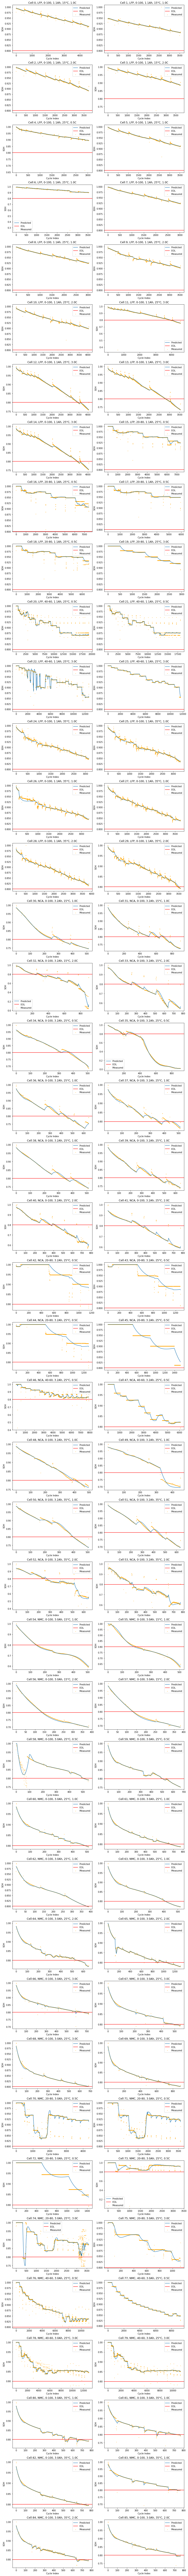

In [69]:
soc_100 = list(metadata[metadata['max_soc']==100].index)
soc_new = [19, 23, 45, 47, 72, 77]
for i in soc_new:
    soc_100.append(i)

fig, axs = plt.subplots(43,2, figsize=(14, 215), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .25, wspace=0.15)
axs = axs.ravel()

for i in metadata.index:
    X = cycle_data[cycle_names[i]].copy()
    to_keep = ['Cycle_Index', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 
               'Charge_Capacity (Ah)', 'Discharge_Capacity (Ah)', 'cathode', 'temperature']
    if i in soc_100:
        to_keep.append('SOH')
    X = X[to_keep]
    
    P = np.diag([1, 20])
    if i in soc_100:
        y_measured=X['SOH']
    else:
        y_measured=ens.predict(X)
    if i in [58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 80, 81, 82, 83, 84, 85]:
        batt_kf = BatteryCapacityKalmanFilter(
            X=X[['Min_Current (A)', 'Max_Voltage (V)']],
            y_measured=y_measured,
            P=P, R=0.000000001, Q=0.1, dt=0.001
        )
        x, cov = batt_kf.run()
    elif i in [30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 49, 50, 51, 52, 53, 54, 55, 56, 57]:
        batt_kf = BatteryCapacityKalmanFilter(
            X=X[['Min_Current (A)', 'Max_Voltage (V)']],
            y_measured=y_measured,
            P=P, R=0.0000001, Q=0.1, dt=0.001
        )
        x, cov = batt_kf.run()
    elif i in [22, 70, 71, 74, 75]:
        batt_kf = BatteryCapacityKalmanFilter(
            X=X[['Min_Current (A)', 'Max_Voltage (V)']],
            y_measured=y_measured,
            P=P, R=0.000001, Q=0.1, dt=0.001
        )
        x, cov = batt_kf.run()        
    else:
        P = np.diag([1, 20])
        batt_kf = BatteryCapacityKalmanFilter(
            X=X[['Min_Current (A)', 'Max_Voltage (V)']],
            y_measured=y_measured,
            P=P, R=0.0001, Q=0.1, dt=0.001
        )
        x, cov = batt_kf.run()
    
    #fixing starting issues of KF
    def model(x, m, n, xf, yf):
        return n*(x-xf)**2+m*(x-xf)+yf
    partial_model = functools.partial(model, xf=100, yf=x[100])
    p0 = [x[100]/100] # Initial guess for m, as long as xf != 0
    best_fit, covar = curve_fit(partial_model, np.array((range(len(x[0:100])))), x[0:100], p0=[p0, p0])
    y_fit = model(np.array((range(len(x[0:100])))), best_fit[0], best_fit[1], 100, x[100])
    x[:100] = y_fit[:100]

    #setting max and min values for KF
    x = np.minimum(x, 1)
    x = np.maximum(x, 0)

    #appending the predicted SOH
    cycle_data[cycle_names[i]]['SOH_KF'] = x
    
    # Visualising the data, with measured voltage values shown in orange and the Kalman filter prediction shown in blue.
    axs[i].plot(x, label='Predicted')
    axs[i].scatter(range(len(y_measured)), y_measured, label='Measured', c='orange', s=1)
    axs[i].axhline(y=0.8 , label='EOL', c='red', linestyle='-')
    axs[i].set_xlabel('Cycle Index')
    axs[i].set_ylabel('SOH')
    axs[i].set_title('Cell:' + str(i) + ', ' +
                     str(metadata['cathode'][i]) + ', ' +
                     str(metadata['min_soc'][i]) + '-' + str(metadata['max_soc'][i]) +  ', ' +
                     str(metadata['capacity_ah'][i]) + 'Ah, ' +
                     str(metadata['temperature'][i]) + 'Â°C, ' +
                     str(metadata['discharge_crate'][i]) + 'C'
                    )
    axs[i].legend()

# Descriptive Analytics

Plot the Cycle Index by Cell ID for all 86 cells cycled by SNL.	

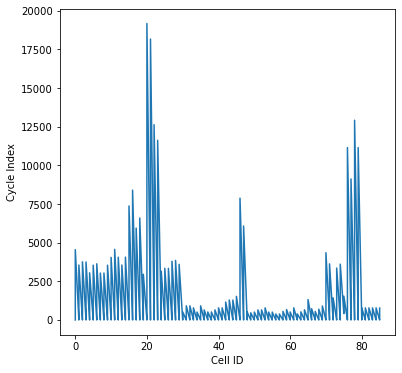

In [30]:
#add cell id
for i in metadata.index:
    cycle = cycle_data[cycle_names[i]]
    cycle['cell_id'] = i

#merge the data
cycle_data_all = cycle_data[cycle_names[metadata.index[0]]].append([cycle_data[cycle_names[i]] for i in metadata.index[1:]])
cycle_data_all.reset_index(drop=True, inplace=True)

#plot the data
x=cycle_data_all['cell_id']
y=cycle_data_all['Cycle_Index']
plt.figure(figsize=(6,6))
plt.xlabel('Cell ID')
plt.ylabel('Cycle Index')
#plt.title('Cycle Index by Cell ID')
plt.plot(x, y)

Comparing average cycles for different SOC cycle ranges

In [44]:
#comparing SOC values
index = metadata[metadata['max_soc']!= 100].index
data = cycle_data[cycle_names[index[0]]].append([cycle_data[cycle_names[i]] for i in index[1:]])
data.reset_index(drop=True, inplace=True)
print(data.groupby('cell_id')['Cycle_Index'].max().mean())
index = metadata[metadata['max_soc']==100].index
data = cycle_data[cycle_names[index[0]]].append([cycle_data[cycle_names[i]] for i in index[1:]])
data.reset_index(drop=True, inplace=True)
print(data.groupby('cell_id')['Cycle_Index'].max().mean())

6974.16
1700.295081967213


Comparing average cycles for different cathode compositions.

In [45]:
#comparing cathode compositions
index = metadata[metadata['cathode']=='LFP'].index
data = cycle_data[cycle_names[index[0]]].append([cycle_data[cycle_names[i]] for i in index[1:]])
data.reset_index(drop=True, inplace=True)
print(data.groupby('cell_id')['Cycle_Index'].max().mean())
index = metadata[metadata['cathode']=='NCA'].index
data = cycle_data[cycle_names[index[0]]].append([cycle_data[cycle_names[i]] for i in index[1:]])
data.reset_index(drop=True, inplace=True)
print(data.groupby('cell_id')['Cycle_Index'].max().mean())
index = metadata[metadata['cathode']=='NMC'].index
data = cycle_data[cycle_names[index[0]]].append([cycle_data[cycle_names[i]] for i in index[1:]])
data.reset_index(drop=True, inplace=True)
print(data.groupby('cell_id')['Cycle_Index'].max().mean())

5656.533333333334
1304.0416666666667
2408.71875


Cells cycled between 0%-100% SOC grouped by cathode, temperature, and c-rate.

In [46]:
meta = metadata[metadata['max_soc']==100][['cathode', 'temperature', 'max_soc', 'discharge_crate', 'EOL']]
meta.groupby(['cathode', 'temperature', 'discharge_crate'])['EOL'].describe()

count     mean          std     min  \
cathode temperature discharge_crate                                        
LFP     15          1.0                2.0     0.00     0.000000     0.0   
                    2.0                2.0     0.00     0.000000     0.0   
        25          0.5                1.0     0.00          NaN     0.0   
                    1.0                4.0     0.00     0.000000     0.0   
                    2.0                2.0     0.00     0.000000     0.0   
                    3.0                4.0  3422.75   451.671986  2838.0   
        35          1.0                4.0     0.00     0.000000     0.0   
                    2.0                2.0  1760.00  2489.015870     0.0   
NCA     15          1.0                2.0   516.00   275.771645   321.0   
                    2.0                2.0   306.50     3.535534   304.0   
        25          0.5                2.0   361.00    32.526912   338.0   
                    1.0                4.0   428.00    48.048587   356.0   
                    2.0                2.0   413.00    24.041631   396.0   
        35          1.0                4.0   406.25    47.380552   344.0   
                    2.0                2.0   274.50     3.535534   272.0   
NMC     15          1.0                2.0   162.50    30.405592   141.0   
                    2.0                2.0   137.00     4.242641   134.0   
        25          0.5                2.0   509.00     1.414214   508.0   
                    1.0                4.0   494.50   130.190885   385.0   
                    2.0                2.0   815.50   379.716341   547.0   
                    3.0                4.0   638.25    90.706027   503.0   
        35          1.0                4.0   720.25    45.631678   657.0   
                    2.0                2.0   716.50     9.192388   710.0   

                                         25%     50%      75%     max  
cathode temperature discharge_crate                                    
LFP     15          1.0                 0.00     0.0     0.00     0.0  
                    2.0                 0.00     0.0     0.00     0.0  
        25          0.5                 0.00     0.0     0.00     0.0  
                    1.0                 0.00     0.0     0.00     0.0  
                    2.0                 0.00     0.0     0.00     0.0  
                    3.0              3293.25  3456.5  3586.00  3940.0  
        35          1.0                 0.00     0.0     0.00     0.0  
                    2.0               880.00  1760.0  2640.00  3520.0  
NCA     15          1.0               418.50   516.0   613.50   711.0  
                    2.0               305.25   306.5   307.75   309.0  
        25          0.5               349.50   361.0   372.50   384.0  
                    1.0               426.50   450.5   452.00   455.0  
                    2.0               404.50   413.0   421.50   430.0  
        35          1.0               391.25   411.0   426.00   459.0  
                    2.0               273.25   274.5   275.75   277.0  
NMC     15          1.0               151.75   162.5   173.25   184.0  
                    2.0               135.50   137.0   138.50   140.0  
        25          0.5               508.50   509.0   509.50   510.0  
                    1.0               411.25   458.0   541.25   677.0  
                    2.0               681.25   815.5   949.75  1084.0  
                    3.0               631.25   676.5   683.50   697.0  
        35          1.0               702.00   733.5   751.75   757.0  
                    2.0               713.25   716.5   719.75   723.0

Plots the SOH of all cells against their cycle indices in blue with their EOL threshold indicated in red.

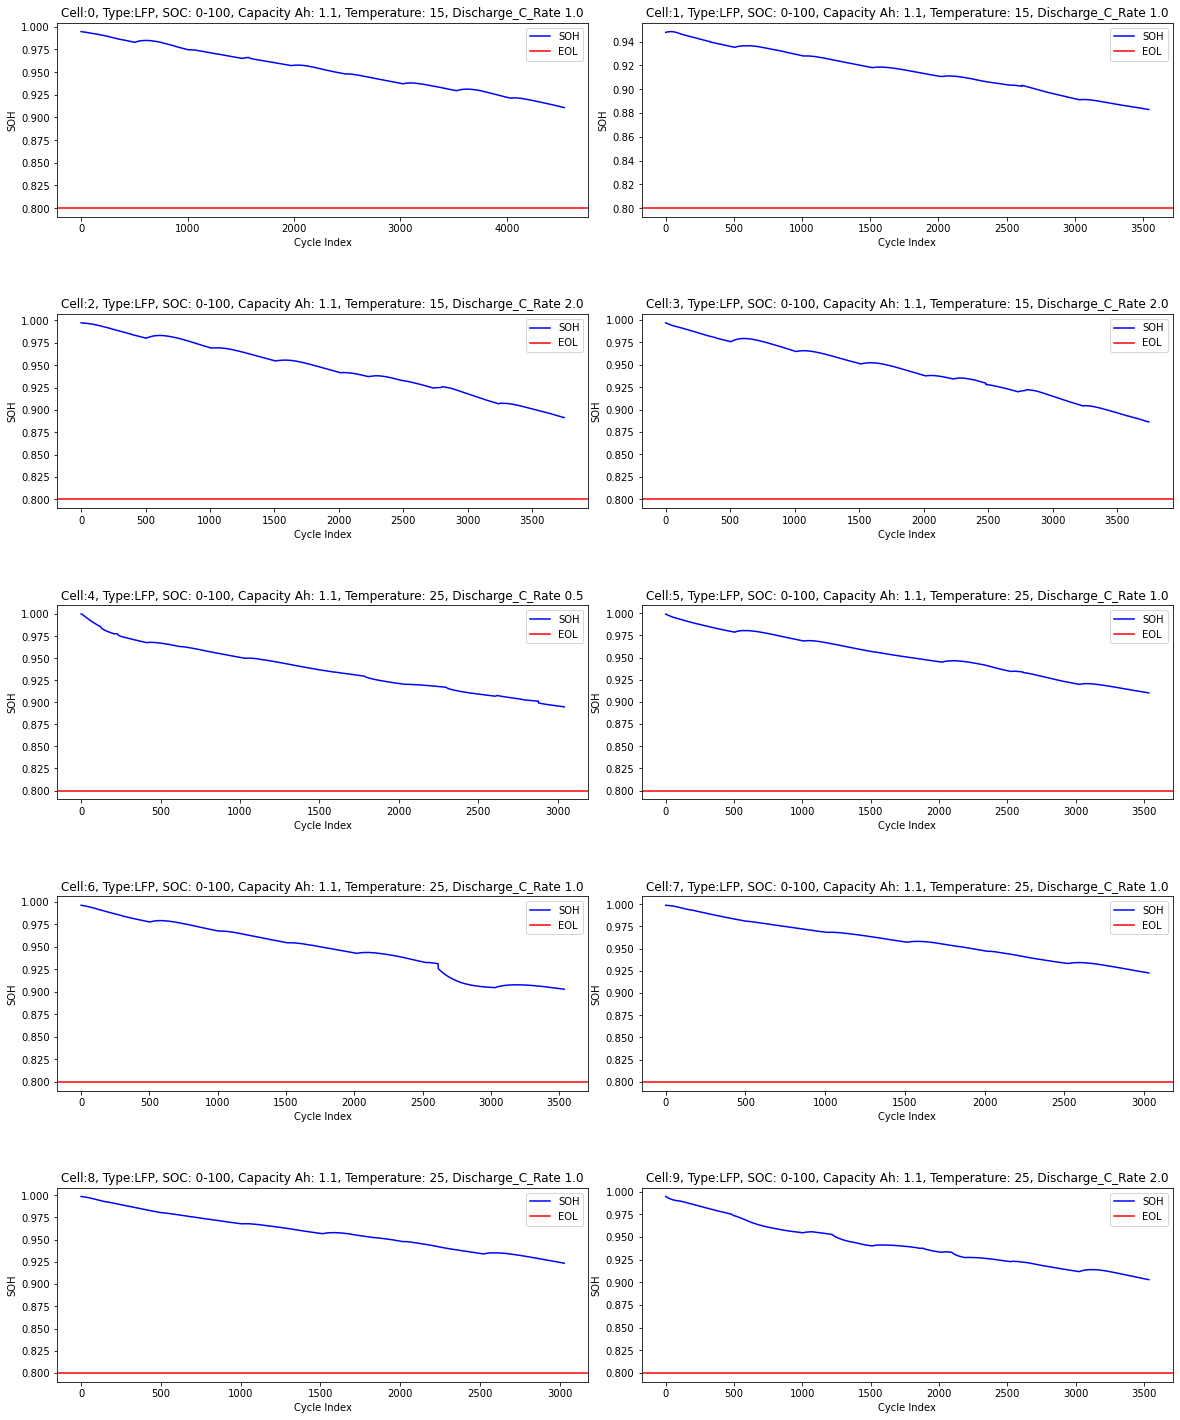

In [47]:
b = 1
c = 10

fig, axs = plt.subplots(int(c/2),2, figsize=(20, int((c/2)*5)), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)
axs = axs.ravel()

for i, j in zip(metadata.index[(b-1)*c:(b*c)], range(c)):
    cycle = cycle_data[cycle_names[i]]
    axs[j].plot(cycle['SOH_KF'], label='SOH', c='blue')
    axs[j].axhline(y=0.8 , label='EOL', c='red', linestyle='-')
    axs[j].set_xlabel('Cycle Index')
    axs[j].set_ylabel('SOH')
    axs[j].set_title('Cell:' + str(i) + 
                     ', Type:' + str(metadata['cathode'][i]) +
                     ', SOC: '+ str(metadata['min_soc'][i]) + '-' + str(metadata['max_soc'][i]) + 
                     ', Capacity Ah: ' + str(metadata['capacity_ah'][i]) + 
                     ', Temperature: ' + str(metadata['temperature'][i]) + 
                     ', Discharge_C_Rate ' + str(metadata['discharge_crate'][i])
                    )
    axs[j].legend()

# Model Training

## Initial Model Evaluation

Train 4 initial models to select the best performing model out of them which will be optimized further.

In [97]:
#load the data
with open('Pandas Pickle Data/cycle_names.pkl', 'rb') as f:
    cycle_names = pickle.load(f)
cycle_data = {}
for name in cycle_names:
    cycle_data[name] = pd.read_pickle('Pandas Pickle Data/' + str(name))

#Loading the metadata
metadata = pd.read_pickle('Pandas Pickle Data/metadata.pkl')

#loading EOL lists
no_EOL = list(metadata[metadata['EOL']==0].index)
EOL = list(metadata[metadata['EOL']!=0].index)

In [98]:
#Transform Test_Time and keep only necessary columns
for c in EOL:
    cycle_data[cycle_names[c]]['Test_Time (s)'] = cycle_data[cycle_names[c]]['Test_Time (s)']/3600
    cycle_data[cycle_names[c]].rename(columns={'Test_Time (s)': 'Test_Time (h)'}, inplace=True)
    cycle_data[cycle_names[c]] = cycle_data[cycle_names[c]][['cell_id', 'Cycle_Index', 'charge_sum', 
                             'SOH_KF', 'RUL', 'Test_Time (h)', 'Min_Current (A)', 'Max_Current (A)', 
                             'Min_Voltage (V)', 'Max_Voltage (V)', 'min_env_temp', 'max_env_temp',
                             'min_cell_temp', 'max_cell_temp']]
    
cycle_data_EOL = cycle_data[cycle_names[EOL[0]]].append([cycle_data[cycle_names[i]] for i in EOL[1:]])
cycle_data_EOL.reset_index(drop=True, inplace=True)

In [99]:
val_data_lfp = cycle_data_EOL[cycle_data_EOL['cell_id']==12]

val_data_nca = cycle_data_EOL[cycle_data_EOL['cell_id']==33]
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==34])
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==36])
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==52])

val_data_nmc = cycle_data_EOL[cycle_data_EOL['cell_id']==57]
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==59])
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==68])
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==85])

val_data = val_data_lfp.append(val_data_nca)
val_data = val_data.append(val_data_nmc)

train_data = cycle_data_EOL[~(cycle_data_EOL['cell_id']==12)]
for i in [33,34,36,52,57,59,68,85]:
    train_data = train_data[~(train_data['cell_id']==i)]

val_data_lfp.reset_index(drop=True, inplace=True)
val_data_nca.reset_index(drop=True, inplace=True)
val_data_nmc.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

train_data.reset_index(drop=True, inplace=True)

#Create model to predict RUL
x_data = train_data.copy()
val = val_data.copy()
val_lfp = val_data_lfp.copy()
val_nca = val_data_nca.copy()
val_nmc = val_data_nmc.copy()

#drop unneeded features
to_drop = ['cell_id', 'SOH_KF']
x_data.drop(to_drop, axis=1, inplace=True)
val.drop(to_drop, axis=1, inplace=True)
val_lfp.drop(to_drop, axis=1, inplace=True)
val_nca.drop(to_drop, axis=1, inplace=True)
val_nmc.drop(to_drop, axis=1, inplace=True)

#Obtaining the target column as a separate variable
y_data = x_data['RUL']

#Dropping the target column
x_data = x_data.drop(columns='RUL')
#extracting label names
labels = x_data.columns

print(x_data.shape)
print(y_data.shape)
print(len(cycle_data_EOL)-len(val))

(37163, 11)
(37163,)
37163


In [14]:
#Neural Network
from keras.layers import Dense, Activation, Dropout
from keras.models import Sequential, load_model
x_NN = x_data.copy().to_numpy().reshape(x_data.shape[0], x_data.shape[1])
y_NN = np.array(y_data.copy()).reshape(x_data.shape[0], 1)

model = Sequential()
model.add(Dense(100, activation='relu', input_shape=(x_data.shape[0], x_data.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))
model.summary()
model.compile(loss='mse', optimizer='adam')
model.fit(x_NN,y_NN,epochs=200,batch_size=25)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 37163, 100)        1200      
_________________________________________________________________
dropout (Dropout)            (None, 37163, 100)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 37163, 100)        10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 37163, 100)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 37163, 1)          101       
Total params: 11,401
Trainable params: 11,401
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
1487/1487 [==============================] - 2s 773us/step - loss: 975011.4375
Epoch 2/200
1487/1487 [====

In [15]:
pred = model.predict(val.drop('RUL', axis=1))
print("NN training score: {:.3f}".format(r2_score(y_data, model.predict(x_data))))
print("NN validation score: {:.3f}".format(r2_score(val['RUL'], pred)))

NN training score: 0.962
NN validation score: 0.699


In [13]:
#Support-Vector Machine
from sklearn import svm
clf = svm.SVR(cache_size=2000)
clf.fit(x_data, y_data)
print("SVM training score: {:.3f}".format(r2_score(y_data, clf.predict(x_data))))
print("SVM validation score: {:.3f}".format(r2_score(val['RUL'], clf.predict(val.drop('RUL', axis=1)))))

SVM training score: 0.069
SVM validation score: 0.109


In [102]:
#Linear Regression
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x_data, y_data)
print("LinearRegression training score: {:.3f}".format(r2_score(y_data, reg.predict(x_data))))
print("LinearRegression validation score: {:.3f}".format(r2_score(val['RUL'], reg.predict(val.drop('RUL', axis=1)))))

LinearRegression training score: 0.923
LinearRegression validation score: 0.980


In [103]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
ens = RandomForestRegressor(random_state = 0)
ens.fit(x_data, y_data)
print("RandomForest training score: {:.3f}".format(r2_score(y_data, ens.predict(x_data))))
print("RandomForest validation score: {:.3f}".format(r2_score(val['RUL'], ens.predict(val.drop('RUL', axis=1)))))

RandomForest training score: 1.000
RandomForest validation score: 0.967


In [16]:
print("NN training MAE: {:.3f}".format(mean_absolute_error(y_data, model.predict(x_data))))
print("SVM training MAE: {:.3f}".format(mean_absolute_error(y_data, clf.predict(x_data))))
print("LinearRegression training MAE: {:.3f}".format(mean_absolute_error(y_data, reg.predict(x_data))))
print("RandomForest training MAE: {:.3f}".format(mean_absolute_error(y_data, ens.predict(x_data))))
print()
print("NN training RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_data, model.predict(x_data)))))
print("SVM training RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_data, clf.predict(x_data)))))
print("LinearRegression training RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_data, reg.predict(x_data)))))
print("RandomForest training RMSE: {:.3f}".format(np.sqrt(mean_squared_error(y_data, ens.predict(x_data)))))

NN training MAE: 142.465
SVM training MAE: 585.652
LinearRegression training MAE: 203.792
RandomForest training MAE: 2.104

NN training RMSE: 200.648
SVM training RMSE: 992.477
LinearRegression training RMSE: 285.321
RandomForest training RMSE: 13.000


In [367]:
print("NN validation MAE: {:.3f}".format(mean_absolute_error(val['RUL'], model.predict(val.drop('RUL', axis=1)))))
print("SVM validation MAE: {:.3f}".format(mean_absolute_error(val['RUL'], clf.predict(val.drop('RUL', axis=1)))))
print("LinearRegression validation MAE: {:.3f}".format(mean_absolute_error(val['RUL'], reg.predict(val.drop('RUL', axis=1)))))
print("RandomForest validation MAE: {:.3f}".format(mean_absolute_error(val['RUL'], ens.predict(val.drop('RUL', axis=1)))))

NN validation MAE: 149.506
SVM validation MAE: 542.062
LinearRegression validation MAE: 87.102
RandomForest validation MAE: 118.125


In [368]:
print("NN validation RMSE: {:.3f}".format(np.sqrt(mean_squared_error(val['RUL'], model.predict(val.drop('RUL', axis=1))))))
print("SVM validation RMSE: {:.3f}".format(np.sqrt(mean_squared_error(val['RUL'], clf.predict(val.drop('RUL', axis=1))))))
print("LinearRegression validation RMSE: {:.3f}".format(np.sqrt(mean_squared_error(val['RUL'], reg.predict(val.drop('RUL', axis=1))))))
print("RandomForest validation RMSE: {:.3f}".format(np.sqrt(mean_squared_error(val['RUL'], ens.predict(val.drop('RUL', axis=1))))))

NN validation RMSE: 353.422
SVM validation RMSE: 975.898
LinearRegression validation RMSE: 146.083
RandomForest validation RMSE: 188.431


In [104]:
plot_data = train_data.copy()
plot_data1 = plot_data[np.logical_or(plot_data['cell_id']==11, plot_data['cell_id']==13)]
plot_data2 = plot_data[np.logical_or(plot_data['cell_id']==14, plot_data['cell_id']==29)]
plot_data = plot_data1.append(plot_data2)

In [105]:
mean_absolute_error(plot_data['RUL'], reg.predict(plot_data[labels]))

293.8476133024986

In [106]:
mean_absolute_error(plot_data['RUL'], ens.predict(plot_data[labels]))

2.7654340366039656

In [108]:
val['RUL_pred'] = reg.predict(val[labels])
val_lfp['RUL_pred'] = reg.predict(val_lfp[labels])
val_nca['RUL_pred'] = reg.predict(val_nca[labels])
val_nmc['RUL_pred'] = reg.predict(val_nmc[labels])

print("LinearRegression  total validation MAE: {:.6f}".format(mean_absolute_error(val['RUL_pred'], val['RUL'])))
print("LinearRegression  total validation MSE: {:.6f}".format(mean_squared_error(val['RUL_pred'], val['RUL'])))
print("LinearRegression  total validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))))
print("LinearRegression  total validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))/(val['RUL'].max()-val['RUL'].min())))
print("LinearRegression  total validation R^2: {:.6f}".format(reg.score(val.drop(['RUL', 'RUL_pred'], axis=1), val['RUL'])))
print()
print("LinearRegression  LFP validation MAE: {:.6f}".format(mean_absolute_error(val_lfp['RUL_pred'], val_lfp['RUL'])))
print("LinearRegression  LFP validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))))
print("LinearRegression  LFP validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))/(val_lfp['RUL'].max()-val_lfp['RUL'].min())))
print("LinearRegression  LFP validation R^2: {:.6f}".format(reg.score(val_lfp.drop(['RUL', 'RUL_pred'], axis=1), val_lfp['RUL'])))
print()
print("LinearRegression  NCA validation MAE: {:.6f}".format(mean_absolute_error(val_nca['RUL_pred'], val_nca['RUL'])))
print("LinearRegression  NCA validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))))
print("LinearRegression  NCA validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))/(val_nca['RUL'].max()-val_nca['RUL'].min())))
print("LinearRegression  NCA validation R^2: {:.6f}".format(reg.score(val_nca.drop(['RUL', 'RUL_pred'], axis=1), val_nca['RUL'])))
print()
print("LinearRegression  NMC validation MAE: {:.6f}".format(mean_absolute_error(val_nmc['RUL_pred'], val_nmc['RUL'])))
print("LinearRegression  NMC validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))))
print("LinearRegression  NMC validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))/(val_nmc['RUL'].max()-val_nmc['RUL'].min())))
print("LinearRegression  NMC validation R^2: {:.6f}".format(reg.score(val_nmc.drop(['RUL', 'RUL_pred'], axis=1), val_nmc['RUL'])))

LinearRegression  total validation MAE: 87.102372
LinearRegression  total validation MSE: 21340.104666
LinearRegression  total validation RMSE: 146.082527
LinearRegression  total validation PE: 0.035981
LinearRegression  total validation R^2: 0.980039

LinearRegression  LFP validation MAE: 68.558527
LinearRegression  LFP validation RMSE: 104.087564
LinearRegression  LFP validation PE: 0.025637
LinearRegression  LFP validation R^2: 0.992111

LinearRegression  NCA validation MAE: 107.475761
LinearRegression  NCA validation RMSE: 193.202055
LinearRegression  NCA validation PE: 0.208192
LinearRegression  NCA validation R^2: 0.207715

LinearRegression  NMC validation MAE: 96.172535
LinearRegression  NMC validation RMSE: 148.038291
LinearRegression  NMC validation PE: 0.151679
LinearRegression  NMC validation R^2: 0.631146


In [107]:
val['RUL_pred'] = ens.predict(val[labels])
val_lfp['RUL_pred'] = ens.predict(val_lfp[labels])
val_nca['RUL_pred'] = ens.predict(val_nca[labels])
val_nmc['RUL_pred'] = ens.predict(val_nmc[labels])

print("RF total validation MAE: {:.6f}".format(mean_absolute_error(val['RUL_pred'], val['RUL'])))
print("RF total validation MSE: {:.6f}".format(mean_squared_error(val['RUL_pred'], val['RUL'])))
print("RF total validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))))
print("RF total validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))/(val['RUL'].max()-val['RUL'].min())))
print("RF total validation R^2: {:.6f}".format(ens.score(val.drop(['RUL', 'RUL_pred'], axis=1), val['RUL'])))
print()
print("RF LFP validation MAE: {:.6f}".format(mean_absolute_error(val_lfp['RUL_pred'], val_lfp['RUL'])))
print("RF LFP validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))))
print("RF LFP validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))/(val_lfp['RUL'].max()-val_lfp['RUL'].min())))
print("RF LFP validation R^2: {:.6f}".format(ens.score(val_lfp.drop(['RUL', 'RUL_pred'], axis=1), val_lfp['RUL'])))
print()
print("RF NCA validation MAE: {:.6f}".format(mean_absolute_error(val_nca['RUL_pred'], val_nca['RUL'])))
print("RF NCA validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))))
print("RF NCA validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))/(val_nca['RUL'].max()-val_nca['RUL'].min())))
print("RF NCA validation R^2: {:.6f}".format(ens.score(val_nca.drop(['RUL', 'RUL_pred'], axis=1), val_nca['RUL'])))
print()
print("RF NMC validation MAE: {:.6f}".format(mean_absolute_error(val_nmc['RUL_pred'], val_nmc['RUL'])))
print("RF NMC validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))))
print("RF NMC validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))/(val_nmc['RUL'].max()-val_nmc['RUL'].min())))
print("RF NMC validation R^2: {:.6f}".format(ens.score(val_nmc.drop(['RUL', 'RUL_pred'], axis=1), val_nmc['RUL'])))

RF total validation MAE: 118.124720
RF total validation MSE: 35506.118492
RF total validation RMSE: 188.430673
RF total validation PE: 0.046411
RF total validation R^2: 0.966788

RF LFP validation MAE: 225.004001
RF LFP validation RMSE: 276.504772
RF LFP validation PE: 0.068105
RF LFP validation R^2: 0.944329

RF NCA validation MAE: 26.198795
RF NCA validation RMSE: 53.638439
RF NCA validation PE: 0.057800
RF NCA validation R^2: 0.938933

RF NMC validation MAE: 39.667836
RF NMC validation RMSE: 52.791306
RF NMC validation PE: 0.054089
RF NMC validation R^2: 0.953094


In General the RF performs the best out of all the different trained models. Only the Linear Regression seems better at first glance as the total MAE and MSE appear to be lower. When diving into the details the Linear Regression performs only better on the one LFP validation cell, on the other cell types it performs much worse. When also looking at the performance of the Linear Regression on the LFP cells in the training data, the MAE is around 294 compared to 3 on the RF. In total, the Linear Regression only performs better on this one cell compared to the RF which lowers the total MAE and MSE below the RF. The total performance on all cells matters the most, which means the RF performs better for almost all cases. Therefore, we will focus further on the RF instead of the Linear Regression to predict the RUL of batteries. 

## Training Random Forest

### Data Preparation

Extract the cycle where cells reach their EOL for successive periods and calculate the RUL for every cell and every row. If the cell doesn't reach its EOL, set the RUL to 0.

In [25]:
#extract cycle_index of when cells reach their EOL
for i in list(metadata.index):
    cycle = cycle_data[cycle_names[i]]
    cycle['EOL_Index'] = 0
    cycle.loc[cycle['SOH_KF']<0.8, 'EOL_Index'] = 1
    cycle['EOL_Index'] = (cycle.EOL_Index.diff(1) != 0).astype('int').cumsum()
    EOL_Index = cycle.groupby('EOL_Index').Cycle_Index.first()
    if len(EOL_Index) > 1:
        cycle['EOL_Index'] = EOL_Index.iloc[-1]
        metadata.loc[metadata.index == i, 'EOL'] = cycle['EOL_Index'][0]
        cycle['EOL_Index'] = cycle['EOL_Index'] - cycle['Cycle_Index']
    else:
        cycle['EOL_Index'] = 0
        metadata.loc[metadata.index == i, 'EOL'] = cycle['EOL_Index'][0]
    if i in [73, 74]:
        cycle['EOL_Index'] = 0
        metadata.loc[metadata.index == i, 'EOL'] = cycle['EOL_Index'][0]
    if i == 83:
        cycle['EOL_Index'] = EOL_Index.iloc[-2]
        metadata.loc[metadata.index == i, 'EOL'] = cycle['EOL_Index'][0]
        cycle['EOL_Index'] = cycle['EOL_Index'] - cycle['Cycle_Index']
    if i == 68:
        cycle['EOL_Index'] = cycle['Cycle_Index'].iloc[-1]
        metadata.loc[metadata.index == i, 'EOL'] = cycle['EOL_Index'][0]
        cycle['EOL_Index'] = cycle['EOL_Index'] - cycle['Cycle_Index']
    cycle.rename({'EOL_Index': 'RUL'}, axis=1, inplace=True)

Separate cells which reach their EOL and which don't.

In [72]:
#loading EOL lists
no_EOL = list(metadata[metadata['EOL']==0].index)
EOL = list(metadata[metadata['EOL']!=0].index)

Calculate the min and max cell and environment temperatures for each cell.

In [27]:
#calculate the min and max cell and environment temperatures for each cell
for i in list(metadata.index): 
    timeseries = timeseries_data[timeseries_names[i]]
    cycle = cycle_data[cycle_names[i]]
    cycle['min_env_temp'] = np.array(timeseries.groupby('Cycle_Index')['Environment_Temperature (C)'].min()[list(cycle['Cycle_Index'])])
    cycle['max_env_temp'] = np.array(timeseries.groupby('Cycle_Index')['Environment_Temperature (C)'].max()[list(cycle['Cycle_Index'])])
    cycle['min_cell_temp'] = np.array(timeseries.groupby('Cycle_Index')['Cell_Temperature (C)'].min()[list(cycle['Cycle_Index'])])
    cycle['max_cell_temp'] = np.array(timeseries.groupby('Cycle_Index')['Cell_Temperature (C)'].max()[list(cycle['Cycle_Index'])])
    cycle.drop('temperature', axis=1, inplace=True)
#fix unrealitic value
cycle_data[cycle_names[70]].loc[cycle_data[cycle_names[70]]['min_cell_temp']<10, 'min_cell_temp'] = 24.807

Perform batching of all cells which reach their EOL with window size 31, stride 2 and shift 5. Drop unnecessary columns and turn cumulative test time in seconds into cycle time in hours. Merge the data.

In [68]:
shift = 5
w = 31
if w > 70:
    stride = 4
elif w > 30:
    stride = 2
else:
    stride = 1
#load the data
cycle_data = {}
for name in cycle_names:
    cycle_data[name] = pd.read_pickle('Pandas Pickle Data/' + str(name))

#loop over dataset of cells which reached their EOL
for c in EOL:
    #drop unnecessary variables and order dataframe columns
    cycle_data[cycle_names[c]] = cycle_data[cycle_names[c]][['cell_id', 'Cycle_Index', 'RUL', 'charge_sum', 'cathode', 
                    'Test_Time (s)', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 
                    'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 'min_cell_temp', 'max_cell_temp']]
    
    cycle_data[cycle_names[c]]['Test_Time (s)'] = cycle_data[cycle_names[c]]['Test_Time (s)']/3600
    cycle_data[cycle_names[c]].rename(columns={'Test_Time (s)': 'Test_Time (h)'}, inplace=True)
    
    EOL0 = cycle_data[cycle_names[c]][cycle_data[cycle_names[c]]['RUL']==0].index[0]
    
    #loop over dataframe with window size 20/w
    for l in range((EOL0 - math.floor(EOL0/w)*w)+w, len(cycle_data[cycle_names[c]]), shift):
        #loop over columns to be shifted in dataframe
        for j in ['Test_Time (h)', 'charge_sum', 'Min_Current (A)', 
                  'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 
                  'min_cell_temp', 'max_cell_temp']:
            #set slice of column and window 20/w
            current_slice = np.array(cycle_data[cycle_names[c]][j])[(l-(w-1)):l+1:stride]
            
            #loop over window to assign new column names and respective shifted value
            if j in ['Test_Time (h)']:
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_mean'] = current_slice.mean()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_max'] = current_slice.max()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_min'] = current_slice.min()
            elif j in ['Min_Current (A)', 'Min_Voltage (V)', 'min_env_temp', 'min_cell_temp']:
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_min'] = current_slice.min()
            elif j in ['Max_Current (A)', 'Max_Voltage (V)', 'max_env_temp', 'max_cell_temp']:
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_max'] = current_slice.max()
            elif j in ['charge_sum']:
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_mean'] = current_slice.mean()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_max'] = current_slice.max()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_min'] = current_slice.min()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_var'] = current_slice.var()
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_skew'] = skew(current_slice)
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_kur'] = kurtosis(current_slice)
                cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l, j + '_max_diff'] = np.abs(
                    current_slice.max()-cycle_data[cycle_names[c]].loc[cycle_data[cycle_names[c]].index == l]['charge_sum'])
                
    #drop non-batched data and reset the index
    cycle_data[cycle_names[c]] = cycle_data[cycle_names[c]].iloc[range((EOL0 - math.floor(EOL0/w)*w)+w, len(cycle_data[cycle_names[c]]), shift)]
    cycle_data[cycle_names[c]].reset_index(drop=True, inplace=True)
    cycle_data[cycle_names[c]].drop(['Test_Time (h)', 'Min_Current (A)', 
                  'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 
                  'min_cell_temp', 'max_cell_temp'], axis=1, inplace=True)

#merge the data
cycle_data_EOL = cycle_data[cycle_names[EOL[0]]].append([cycle_data[cycle_names[i]] for i in EOL[1:]])
cycle_data_EOL.reset_index(drop=True, inplace=True)

Plot the correlation matrix between the variables for cycle_data_EOL.

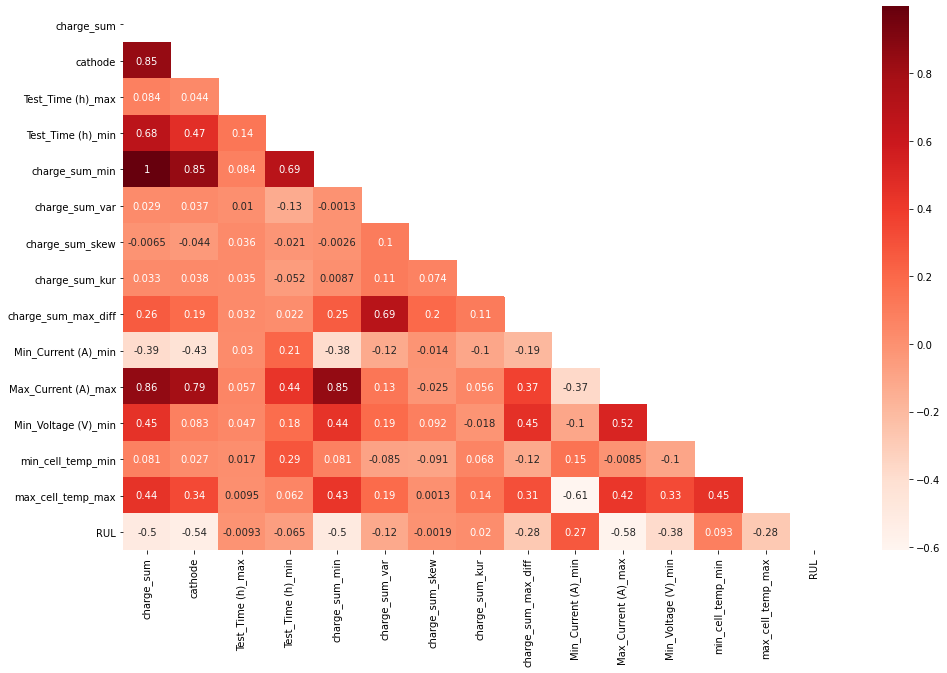

In [74]:
#plotting correlation matrix for cycle_data_EOL
plt.figure(figsize=(16,10))
cycle11 = cycle_data_EOL.copy()
cor = cycle11[['charge_sum', 'cathode', 'Test_Time (h)_max', 'Test_Time (h)_min',
       'charge_sum_min', 'charge_sum_var', 'charge_sum_skew', 'charge_sum_kur',
       'charge_sum_max_diff', 'Min_Current (A)_min', 'Max_Current (A)_max',
       'Min_Voltage (V)_min', 'min_cell_temp_min', 'max_cell_temp_max', 'RUL']].corr()
mask = np.triu(np.ones_like(cor, dtype=bool))
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, mask=mask)
plt.show()

In [73]:
#saving the data
cycle_data_EOL.to_pickle('Pandas Pickle Data/cycle_data_EOL.pkl')

### With non-windowed data

Running a model with non-windowed data to compare its performance to a model trained on windowed data.

In [73]:
#load the data
with open('Pandas Pickle Data/cycle_names.pkl', 'rb') as f:
    cycle_names = pickle.load(f)
cycle_data = {}
for name in cycle_names:
    cycle_data[name] = pd.read_pickle('Pandas Pickle Data/' + str(name))

In [74]:
#merge the data
cycle_data_all = cycle_data[cycle_names[EOL[0]]].append([cycle_data[cycle_names[i]] for i in EOL[1:]])
cycle_data_all.reset_index(drop=True, inplace=True)
cycle_data_all.drop(['Start_Time', 'End_Time', 'Charge_Capacity (Ah)', 'Charge_Energy (Wh)', 
                     'Discharge_Energy (Wh)', 'Discharge_Capacity (Ah)', 'SOH', 'SOH_KF'], axis=1, inplace=True)
cycle_data_all['Test_Time (s)'] = cycle_data_all['Test_Time (s)']/3600
cycle_data_all.rename(columns={'Test_Time (s)': 'Test_Time (h)'}, inplace=True)

In [75]:
val_data_lfp = cycle_data_all[cycle_data_all['cell_id']==12]

val_data_nca = cycle_data_all[cycle_data_all['cell_id']==33]
val_data_nca = val_data_nca.append(cycle_data_all[cycle_data_all['cell_id']==34])
val_data_nca = val_data_nca.append(cycle_data_all[cycle_data_all['cell_id']==36])
val_data_nca = val_data_nca.append(cycle_data_all[cycle_data_all['cell_id']==52])

val_data_nmc = cycle_data_all[cycle_data_all['cell_id']==57]
val_data_nmc = val_data_nmc.append(cycle_data_all[cycle_data_all['cell_id']==59])
val_data_nmc = val_data_nmc.append(cycle_data_all[cycle_data_all['cell_id']==68])
val_data_nmc = val_data_nmc.append(cycle_data_all[cycle_data_all['cell_id']==85])

val_data = val_data_lfp.append(val_data_nca)
val_data = val_data.append(val_data_nmc)

train_data = cycle_data_all[~(cycle_data_all['cell_id']==12)]
for i in [33,34,36,52,57,59,68,85]:
    train_data = train_data[~(train_data['cell_id']==i)]

val_data_lfp.reset_index(drop=True, inplace=True)
val_data_nca.reset_index(drop=True, inplace=True)
val_data_nmc.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

train_data.reset_index(drop=True, inplace=True)

In [76]:
#Create model to predict RUL
x_data = train_data.copy()
val = val_data.copy()
val_lfp = val_data_lfp.copy()
val_nca = val_data_nca.copy()
val_nmc = val_data_nmc.copy()

#drop unneeded features
to_keep = ['RUL', 'cathode', 'Test_Time (h)', 'charge_sum', 'max_cell_temp', 'min_cell_temp', 
           'Min_Current (A)', 'Max_Current (A)', 'Max_Voltage (V)', 'Min_Voltage (V)', 'Cycle_Index']
x_data = x_data[to_keep]
val = val[to_keep]
val_lfp = val_lfp[to_keep]
val_nca = val_nca[to_keep]
val_nmc = val_nmc[to_keep]

#Obtaining the target column as a separate variable
y_data = x_data['RUL']

#Dropping the target column
x_data = x_data.drop(columns='RUL')
#extracting label names
labels = x_data.columns

print(x_data.shape)
print(y_data.shape)
print(len(cycle_data_all)-len(val))
print()

#Training the RF
ens = RandomForestRegressor(n_estimators=90, criterion='mse', max_depth=15, min_samples_leaf=2, random_state = 0)
ens.fit(x_data, y_data)
print("RandomForestRegressor training score: {:.3f}".format(ens.score(x_data, y_data)))
print("RandomForestRegressor validation score: {:.3f}".format(ens.score(val.drop('RUL', axis=1),val['RUL'])))
display(pd.DataFrame([ens.feature_importances_],columns=labels).sort_values(0, axis=1, ascending=False))

(37163, 10)
(37163,)
37163

RandomForestRegressor training score: 1.000
RandomForestRegressor validation score: 0.968


charge_sum  Max_Current (A)   cathode  Max_Voltage (V)  Cycle_Index  \
0    0.473557         0.155158  0.152547          0.10157     0.071518   

   Test_Time (h)  max_cell_temp  min_cell_temp  Min_Voltage (V)  \
0       0.022908       0.015133        0.00594         0.001202   

   Min_Current (A)  
0         0.000467

The RF trained on the non-windowed data performs worse compared to the one trained on the windowed data (for almost all validation data). The MAE for all validation cells is 116 and the RMSE is 184 compared to 95 and 144 of the windowed RF. Only the performance on NCA cells is better compared to the windowed RF with a MAE of 23 compared to 33. Thus, the windowed RF is used.

In [77]:
val['RUL_pred'] = ens.predict(val[labels])
val_lfp['RUL_pred'] = ens.predict(val_lfp[labels])
val_nca['RUL_pred'] = ens.predict(val_nca[labels])
val_nmc['RUL_pred'] = ens.predict(val_nmc[labels])

print("RF total training MAE: {:.6f}".format(mean_absolute_error(ens.predict(x_data), y_data)))
print("RF total training MSE: {:.6f}".format(mean_squared_error(ens.predict(x_data), y_data)))

RF total training MAE: 4.138756
RF total training MSE: 426.455574


In [96]:
print("RF total validation MAE: {:.6f}".format(mean_absolute_error(val['RUL_pred'], val['RUL'])))
print("RF total validation MSE: {:.6f}".format(mean_squared_error(val['RUL_pred'], val['RUL'])))
print("RF total validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))))
print("RF total validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))/(val['RUL'].max()-val['RUL'].min())))
print("RF total validation R^2: {:.6f}".format(ens.score(val.drop(['RUL', 'RUL_pred'], axis=1), val['RUL'])))
print()
print("RF LFP validation MAE: {:.6f}".format(mean_absolute_error(val_lfp['RUL_pred'], val_lfp['RUL'])))
print("RF LFP validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))))
print("RF LFP validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))/(val_lfp['RUL'].max()-val_lfp['RUL'].min())))
print("RF LFP validation R^2: {:.6f}".format(ens.score(val_lfp.drop(['RUL', 'RUL_pred'], axis=1), val_lfp['RUL'])))
print()
print("RF NCA validation MAE: {:.6f}".format(mean_absolute_error(val_nca['RUL_pred'], val_nca['RUL'])))
print("RF NCA validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))))
print("RF NCA validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))/(val_nca['RUL'].max()-val_nca['RUL'].min())))
print("RF NCA validation R^2: {:.6f}".format(ens.score(val_nca.drop(['RUL', 'RUL_pred'], axis=1), val_nca['RUL'])))
print()
print("RF NMC validation MAE: {:.6f}".format(mean_absolute_error(val_nmc['RUL_pred'], val_nmc['RUL'])))
print("RF NMC validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))))
print("RF NMC validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))/(val_nmc['RUL'].max()-val_nmc['RUL'].min())))
print("RF NMC validation R^2: {:.6f}".format(ens.score(val_nmc.drop(['RUL', 'RUL_pred'], axis=1), val_nmc['RUL'])))

RF total validation MAE: 116.466970
RF total validation MSE: 33732.792756
RF total validation RMSE: 183.664893
RF total validation PE: 0.045238
RF total validation R^2: 0.968447

RF LFP validation MAE: 218.305779
RF LFP validation RMSE: 268.692606
RF LFP validation PE: 0.066180
RF LFP validation R^2: 0.947430

RF NCA validation MAE: 23.108938
RF NCA validation RMSE: 45.722012
RF NCA validation PE: 0.049269
RF NCA validation R^2: 0.955628

RF NMC validation MAE: 47.631778
RF NMC validation RMSE: 63.407286
RF NMC validation PE: 0.064966
RF NMC validation R^2: 0.932332


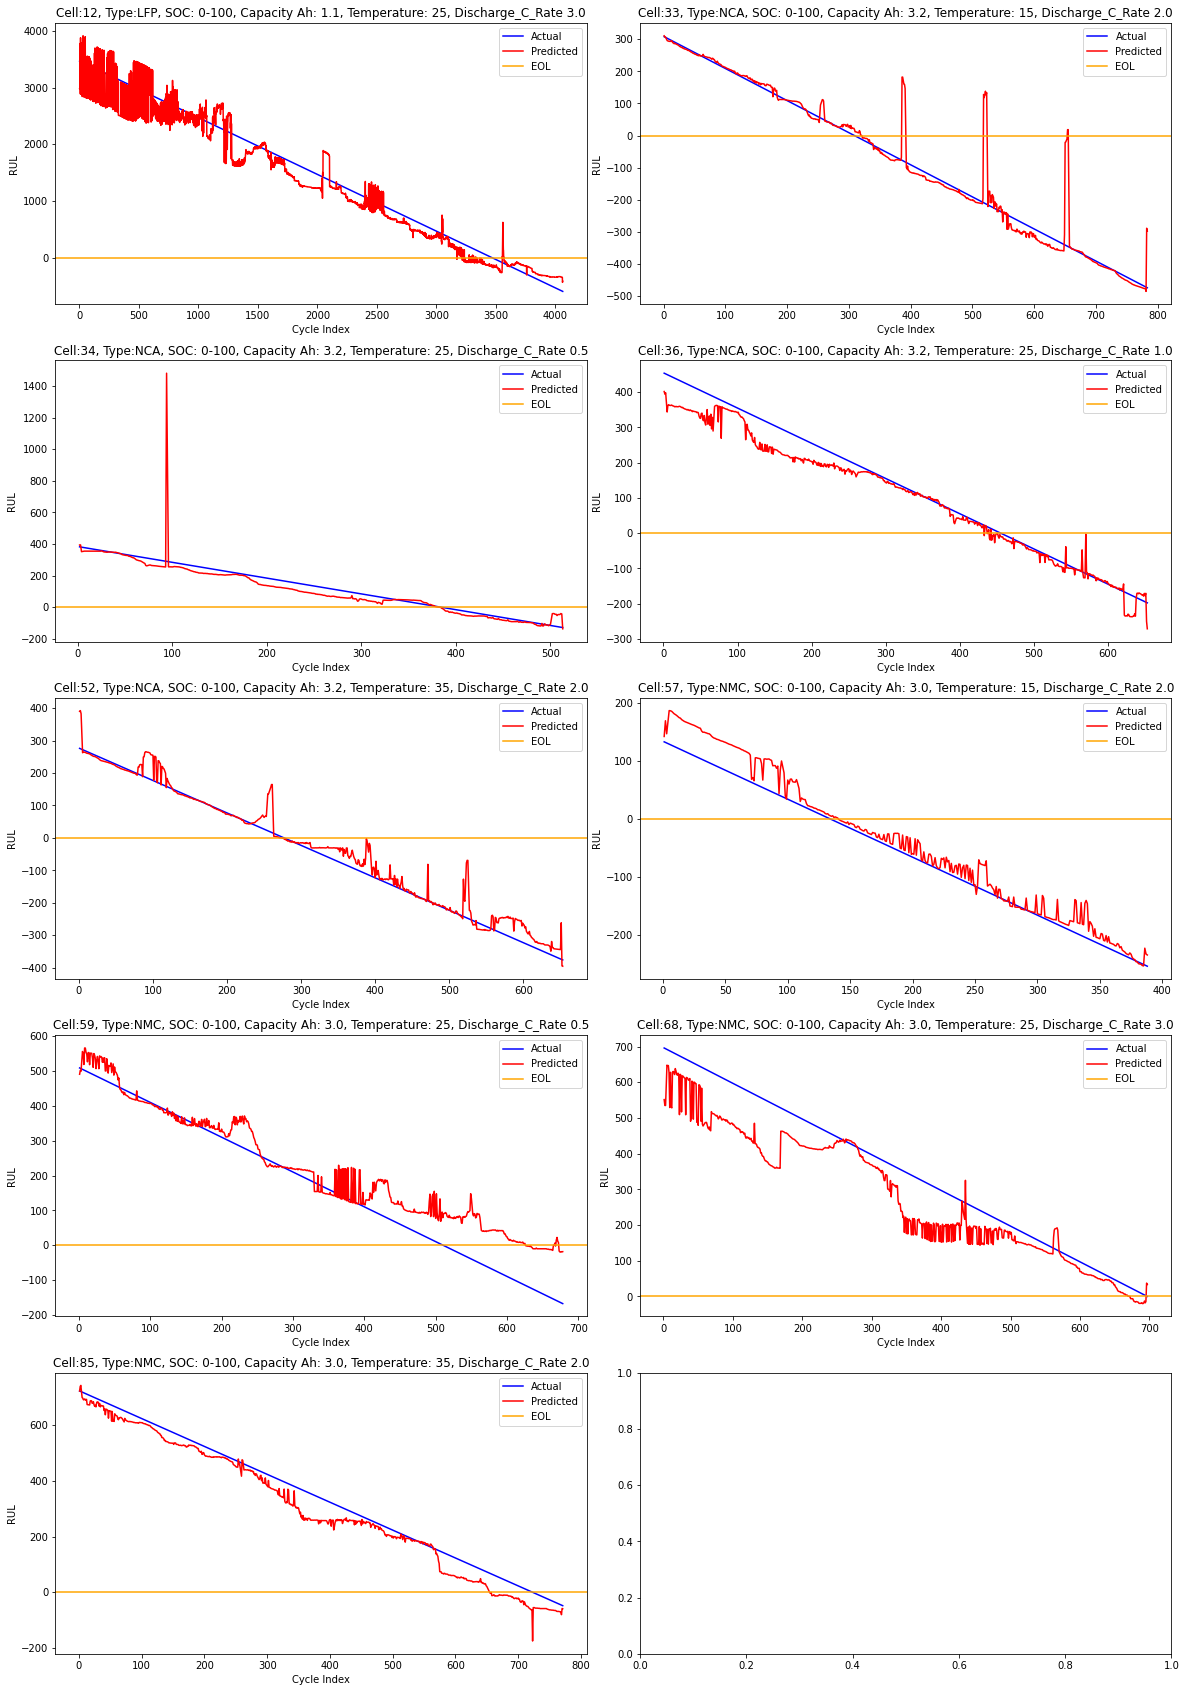

In [78]:
fig, axs = plt.subplots(5,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i, j in zip(validation, range(len(validation))):
    val['cell_id'] = val_data['cell_id']
    axs[j].plot(val[val['cell_id']==i]['Cycle_Index'], val[val['cell_id']==i]['RUL'], label='Actual', c='blue')
    axs[j].plot(val[val['cell_id']==i]['Cycle_Index'], val[val['cell_id']==i]['RUL_pred'], label='Predicted', c='red') 
    axs[j].axhline(y=0 , label='EOL', c='orange', linestyle='-')
    axs[j].set_xlabel('Cycle Index')
    axs[j].set_ylabel('RUL')
    axs[j].set_title('Cell:' + str(i) + 
                     ', Type:' + str(metadata['cathode'][i]) +
                     ', SOC: '+ str(metadata['min_soc'][i]) + '-' + str(metadata['max_soc'][i]) + 
                     ', Capacity Ah: ' + str(metadata['capacity_ah'][i]) + 
                     ', Temperature: ' + str(metadata['temperature'][i]) + 
                     ', Discharge_C_Rate ' + str(metadata['discharge_crate'][i])
                    )
    axs[j].legend()

In [79]:
print("RF total training MAE: {:.6f}".format(mean_absolute_error(val['RUL_pred'], val['RUL'])))
print("RF total training MSE: {:.6f}".format(mean_squared_error(val['RUL_pred'], val['RUL'])))

RF total training MAE: 116.466970
RF total training MSE: 33732.792756


### With windowed data

In [48]:
#Loading the cycle_data_EOL
cycle_data_EOL = pd.read_pickle('Pandas Pickle Data/cycle_data_EOL.pkl')

Splitting the data in 80% training and 20% validation by selecting 9 cells as validation datasets to see the performance of the model on each type of cell with different temperatures and C-rates. Only 1 of lfp is included as there are only 5 lfp cells in total which reached their EOL. 4 NCA and 4 NMC cells were included aswell.
The validation data is not randomly selected from the training data but rather individual cells are separated to see how the model performs when predicting the RUL of whole cells. The cells were chosen to reflect a range in temperature, cathode, and c-rates.

In [49]:
validation = [12,33,34,36,52,57,59,68,85]

val_meta = metadata.copy()
val_meta = val_meta[['cathode', 'temperature', 'discharge_crate']]
val_meta = val_meta.iloc[validation]
val_meta

cathode  temperature  discharge_crate
12     LFP           25              3.0
33     NCA           15              2.0
34     NCA           25              0.5
36     NCA           25              1.0
52     NCA           35              2.0
57     NMC           15              2.0
59     NMC           25              0.5
68     NMC           25              3.0
85     NMC           35              2.0

In [50]:
val_data_lfp = cycle_data_EOL[cycle_data_EOL['cell_id']==12]

val_data_nca = cycle_data_EOL[cycle_data_EOL['cell_id']==33]
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==34])
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==36])
val_data_nca = val_data_nca.append(cycle_data_EOL[cycle_data_EOL['cell_id']==52])

val_data_nmc = cycle_data_EOL[cycle_data_EOL['cell_id']==57]
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==59])
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==68])
val_data_nmc = val_data_nmc.append(cycle_data_EOL[cycle_data_EOL['cell_id']==85])

val_data = val_data_lfp.append(val_data_nca)
val_data = val_data.append(val_data_nmc)

train_data = cycle_data_EOL[~(cycle_data_EOL['cell_id']==12)]
for i in [33,34,36,52,57,59,68,85]:
    train_data = train_data[~(train_data['cell_id']==i)]

val_data_lfp.reset_index(drop=True, inplace=True)
val_data_nca.reset_index(drop=True, inplace=True)
val_data_nmc.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)

train_data.reset_index(drop=True, inplace=True)

In [51]:
#Create model to predict RUL
x_data = train_data.copy()
val = val_data.copy()
val_lfp = val_data_lfp.copy()
val_nca = val_data_nca.copy()
val_nmc = val_data_nmc.copy()

#drop unneeded features
to_drop = ['cell_id', 'charge_sum_mean', 'charge_sum_max', 
           'Max_Voltage (V)_max', 'max_env_temp_max', 'min_env_temp_min', 'Test_Time (h)_mean']
x_data.drop(to_drop, axis=1, inplace=True)
val.drop(to_drop, axis=1, inplace=True)
val_lfp.drop(to_drop, axis=1, inplace=True)
val_nca.drop(to_drop, axis=1, inplace=True)
val_nmc.drop(to_drop, axis=1, inplace=True)

#Obtaining the target column as a separate variable
y_data = x_data['RUL']

#Dropping the target column
x_data = x_data.drop(columns='RUL')
#extracting label names
labels = x_data.columns

print(x_data.shape)
print(y_data.shape)
print(len(cycle_data_EOL)-len(val))

(7113, 15)
(7113,)
7113


Perform GridSearchCV to optimize the RF according to MSE depending on the number of estimators between 5 and 100 (every fifth), the maximum tree depth between 1 and 20 and the minimum sample leaf size between 1 and 10.

In [87]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_estimators':range(5,105,5), 'max_depth':range(1,21), 'min_samples_leaf':range(1,11)}
ens = RandomForestRegressor(criterion='mse', random_state = 0)
ens_grid = GridSearchCV(ens, parameters)
ens_grid.fit(x_data, y_data)

GridSearchCV(estimator=RandomForestRegressor(random_state=0),
             param_grid={'max_depth': range(1, 21),
                         'min_samples_leaf': range(1, 11),
                         'n_estimators': range(5, 105, 5)})

Train a RandomForestRegressor with a max depth of 15, a min sample leaf size of 2, with 90 estimators and random state 0.

In [52]:
ens = RandomForestRegressor(n_estimators=90, criterion='mse', max_depth=15, min_samples_leaf=2, random_state = 0)
ens.fit(x_data, y_data)
print("RandomForestRegressor training score: {:.3f}".format(ens.score(x_data, y_data)))
print("RandomForestRegressor validation score: {:.3f}".format(ens.score(val.drop('RUL', axis=1),val['RUL'])))
display(pd.DataFrame([ens.feature_importances_],columns=labels).sort_values(0, axis=1, ascending=False))

RandomForestRegressor training score: 1.000
RandomForestRegressor validation score: 0.981


Min_Voltage (V)_min  charge_sum  charge_sum_min  cathode  \
0             0.451606    0.242174        0.079424  0.07681   

   Max_Current (A)_max  Test_Time (h)_min  Cycle_Index  max_cell_temp_max  \
0             0.066083           0.048994     0.014799           0.009861   

   min_cell_temp_min  Test_Time (h)_max  Min_Current (A)_min  charge_sum_var  \
0            0.00718           0.001945             0.000474        0.000299   

   charge_sum_max_diff  charge_sum_skew  charge_sum_kur  
0             0.000155         0.000127        0.000068

Plot the feature importance of each feature.

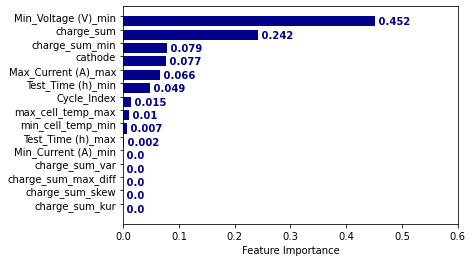

In [85]:
importances = ens.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in ens.estimators_], axis=0)

forest_importances = pd.Series(importances, index=labels)
forest_importances = forest_importances.sort_values(ascending=True)

x = forest_importances.index
y = forest_importances.values.round(3)

fig, ax = plt.subplots()    
width = 0.75 # the width of the bars 
ind = np.arange(len(y))  # the x locations for the groups
ax.barh(ind, y, width, color="darkblue")
ax.set_yticks(ind+width/2)
ax.set_yticklabels(x, minor=False)
ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
plt.xlabel('Feature Importance')
for i, v in enumerate(y):
    plt.text(v, i, " "+str(v), color='darkblue', va='center', fontweight='bold')

Calculate all relevant metrics for the validation data (seperated by cathode and in total) such as MAE, MSE, RMSE, MAPE, R^2 and the percentage error accrding to Ng et al. (2020) p.7. 
As can be seen the model performs adequate on the validation data with an R^2 of 98%, a RMSE of 144, a MAE of 95, and a percentage error of 3.6%. When looking at the performance of the RF separated by cathode, the prediction on LFP cells are worse as there are only 4 cells for the model to train on which results in an MAE of 167 and a PE of 5.1%. In compariosn, the predictions on NCA and NMC cells are better with MAEs of 34 and PEs of around 6% and 5% respectively.

In [13]:
val['RUL_pred'] = ens.predict(val[labels])
val_lfp['RUL_pred'] = ens.predict(val_lfp[labels])
val_nca['RUL_pred'] = ens.predict(val_nca[labels])
val_nmc['RUL_pred'] = ens.predict(val_nmc[labels])

print("RF total training MAE: {:.6f}".format(mean_absolute_error(ens.predict(x_data), y_data)))
print("RF total training MSE: {:.6f}".format(mean_squared_error(ens.predict(x_data), y_data)))

RF total training MAE: 6.964294
RF total training MSE: 392.628358


In [15]:
print("RF total validation MAE: {:.6f}".format(mean_absolute_error(val['RUL_pred'], val['RUL'])))
print("RF total validation MSE: {:.6f}".format(mean_squared_error(val['RUL_pred'], val['RUL'])))
print("RF total validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))))
print("RF total validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val['RUL_pred'], val['RUL']))/(val['RUL'].max()-val['RUL'].min())))
print("RF total validation R^2: {:.6f}".format(ens.score(val.drop(['RUL', 'RUL_pred'], axis=1), val['RUL'])))
print()
print("RF LFP validation MAE: {:.6f}".format(mean_absolute_error(val_lfp['RUL_pred'], val_lfp['RUL'])))
print("RF LFP validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))))
print("RF LFP validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_lfp['RUL_pred'], val_lfp['RUL']))/(val_lfp['RUL'].max()-val_lfp['RUL'].min())))
print("RF LFP validation R^2: {:.6f}".format(ens.score(val_lfp.drop(['RUL', 'RUL_pred'], axis=1), val_lfp['RUL'])))
print()
print("RF NCA validation MAE: {:.6f}".format(mean_absolute_error(val_nca['RUL_pred'], val_nca['RUL'])))
print("RF NCA validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))))
print("RF NCA validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nca['RUL_pred'], val_nca['RUL']))/(val_nca['RUL'].max()-val_nca['RUL'].min())))
print("RF NCA validation R^2: {:.6f}".format(ens.score(val_nca.drop(['RUL', 'RUL_pred'], axis=1), val_nca['RUL'])))
print()
print("RF NMC validation MAE: {:.6f}".format(mean_absolute_error(val_nmc['RUL_pred'], val_nmc['RUL'])))
print("RF NMC validation RMSE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))))
print("RF NMC validation PE: {:.6f}".format(np.sqrt(mean_squared_error(val_nmc['RUL_pred'], val_nmc['RUL']))/(val_nmc['RUL'].max()-val_nmc['RUL'].min())))
print("RF NMC validation R^2: {:.6f}".format(ens.score(val_nmc.drop(['RUL', 'RUL_pred'], axis=1), val_nmc['RUL'])))

RF total validation MAE: 94.569200
RF total validation MSE: 20829.397354
RF total validation RMSE: 144.323932
RF total validation PE: 0.035991
RF total validation R^2: 0.980527

RF LFP validation MAE: 166.659000
RF LFP validation RMSE: 206.051579
RF LFP validation PE: 0.051384
RF LFP validation R^2: 0.968367

RF NCA validation MAE: 33.830297
RF NCA validation RMSE: 54.695563
RF NCA validation PE: 0.062083
RF NCA validation R^2: 0.929816

RF NMC validation MAE: 33.869891
RF NMC validation RMSE: 47.241389
RF NMC validation PE: 0.050364
RF NMC validation R^2: 0.959891


In [125]:
plot_data = val.copy()
plot_data['cell_id'] = val_data['cell_id']
plot_data = plot_data[plot_data['cell_id']==validation[8]]
plot_data.reset_index(inplace=True, drop=True)
print("RF validation cell 85 MAE: {:.6f}".format(mean_absolute_error(plot_data['RUL_pred'], plot_data['RUL'])))
print("RF validation cell 85 RMSE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL']))))
print("RF validation cell 85 PE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL'])/(plot_data['RUL'].max()-plot_data['RUL'].min()))))
print("RF validation cell 85 R^2: {:.6f}".format(ens.score(plot_data[labels], plot_data['RUL'])))

RF validation cell 85 MAE: 31.383348
RF validation cell 85 RMSE: 35.790514
RF validation cell 85 PE: 1.319256
RF validation cell 85 R^2: 0.972068


Plot the predicted RUL of all validation cells.

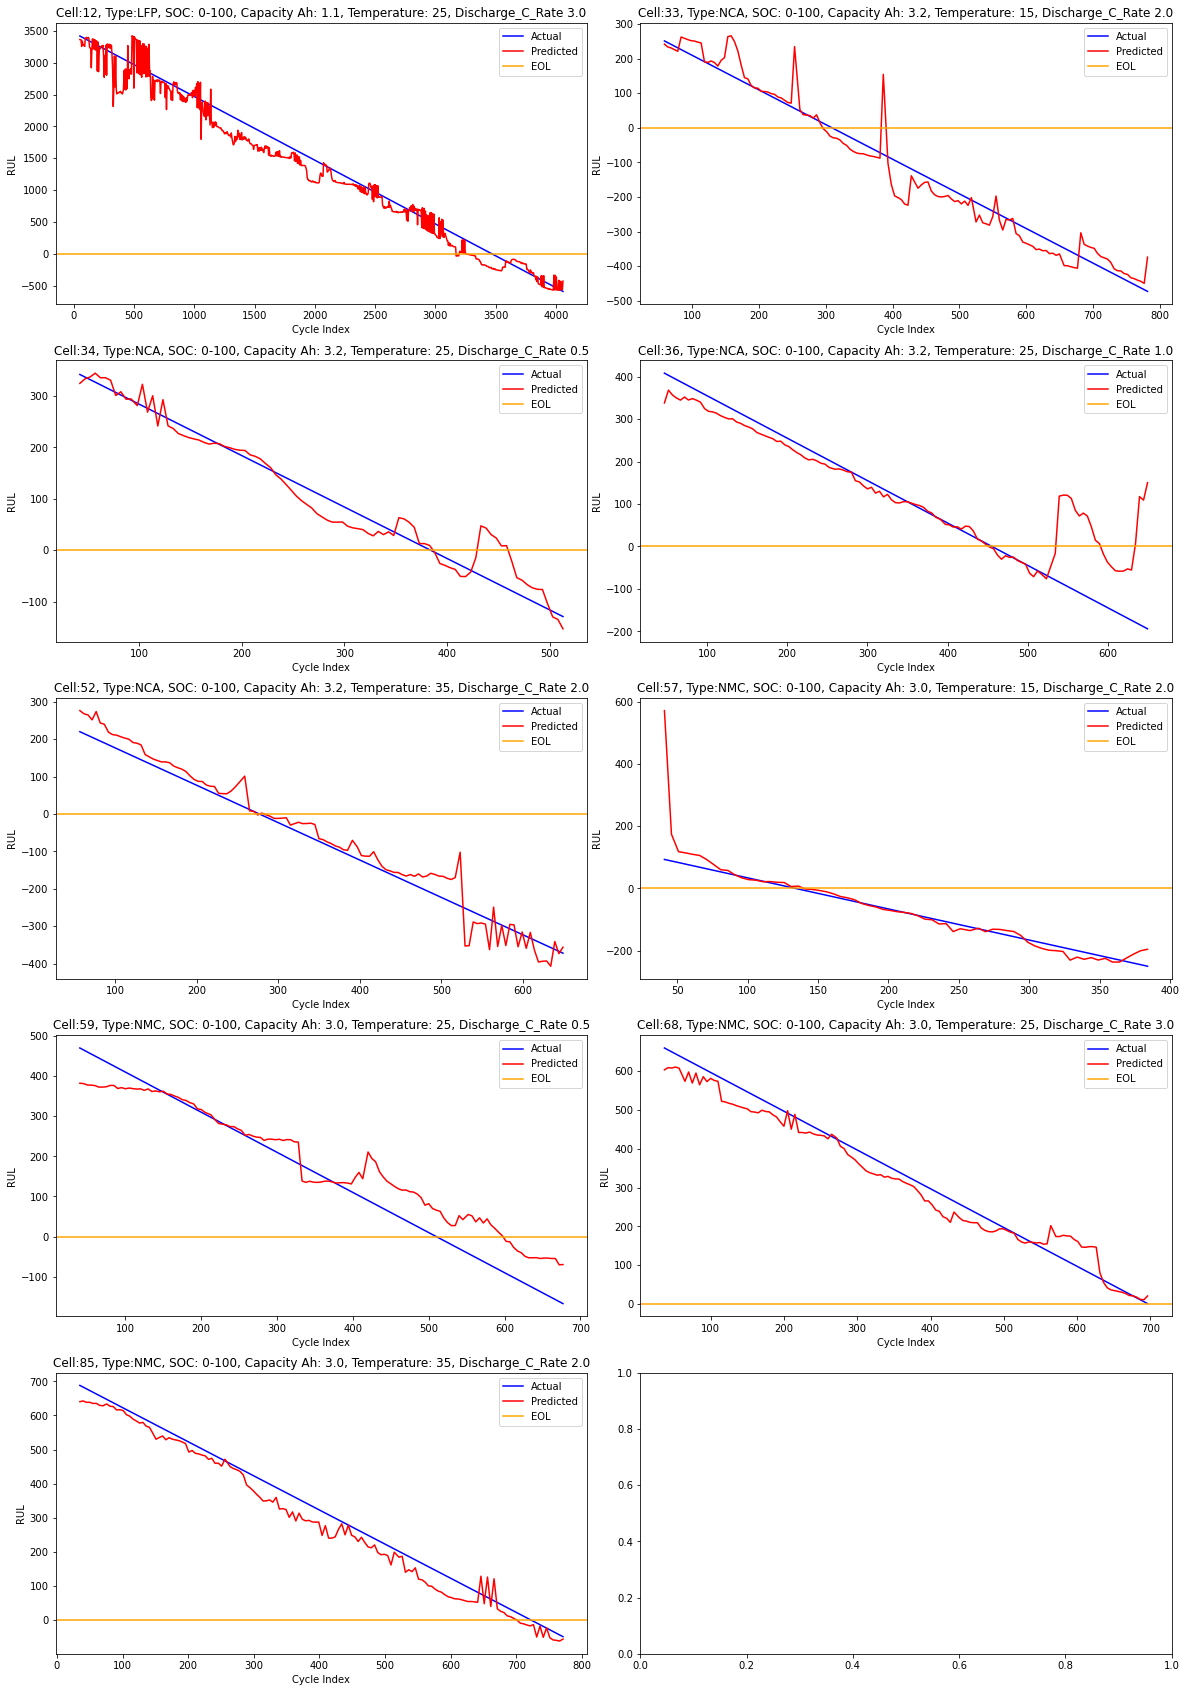

In [44]:
fig, axs = plt.subplots(5,2, figsize=(20, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()

for i, j in zip(validation, range(len(validation))):
    val['cell_id'] = val_data['cell_id']
    axs[j].plot(val[val['cell_id']==i]['Cycle_Index'], val[val['cell_id']==i]['RUL'], label='Actual', c='blue')
    axs[j].plot(val[val['cell_id']==i]['Cycle_Index'], val[val['cell_id']==i]['RUL_pred'], label='Predicted', c='red') 
    axs[j].axhline(y=0 , label='EOL', c='orange', linestyle='-')
    axs[j].set_xlabel('Cycle Index')
    axs[j].set_ylabel('RUL')
    axs[j].set_title('Cell:' + str(i) + 
                     ', Type:' + str(metadata['cathode'][i]) +
                     ', SOC: '+ str(metadata['min_soc'][i]) + '-' + str(metadata['max_soc'][i]) + 
                     ', Capacity Ah: ' + str(metadata['capacity_ah'][i]) + 
                     ', Temperature: ' + str(metadata['temperature'][i]) + 
                     ', Discharge_C_Rate ' + str(metadata['discharge_crate'][i])
                    )
    axs[j].legend()

In [60]:
tree_labels = labels.copy()
tree_labels = [item.replace('Min_Current (A)_min', 'Min_Current (A)') for item in tree_labels]
tree_labels = [item.replace('Max_Current (A)_max', 'Max_Current (A)') for item in tree_labels]
tree_labels = [item.replace('Min_Voltage (V)_min', 'Min_Voltage (V)') for item in tree_labels]
tree_labels = [item.replace('Max_Voltage (V)_max', 'Max_Voltage (V)') for item in tree_labels]
tree_labels = [item.replace('min_cell_temp_min', 'min_cell_temp') for item in tree_labels]
tree_labels = [item.replace('max_cell_temp_max', 'max_cell_temp') for item in tree_labels]

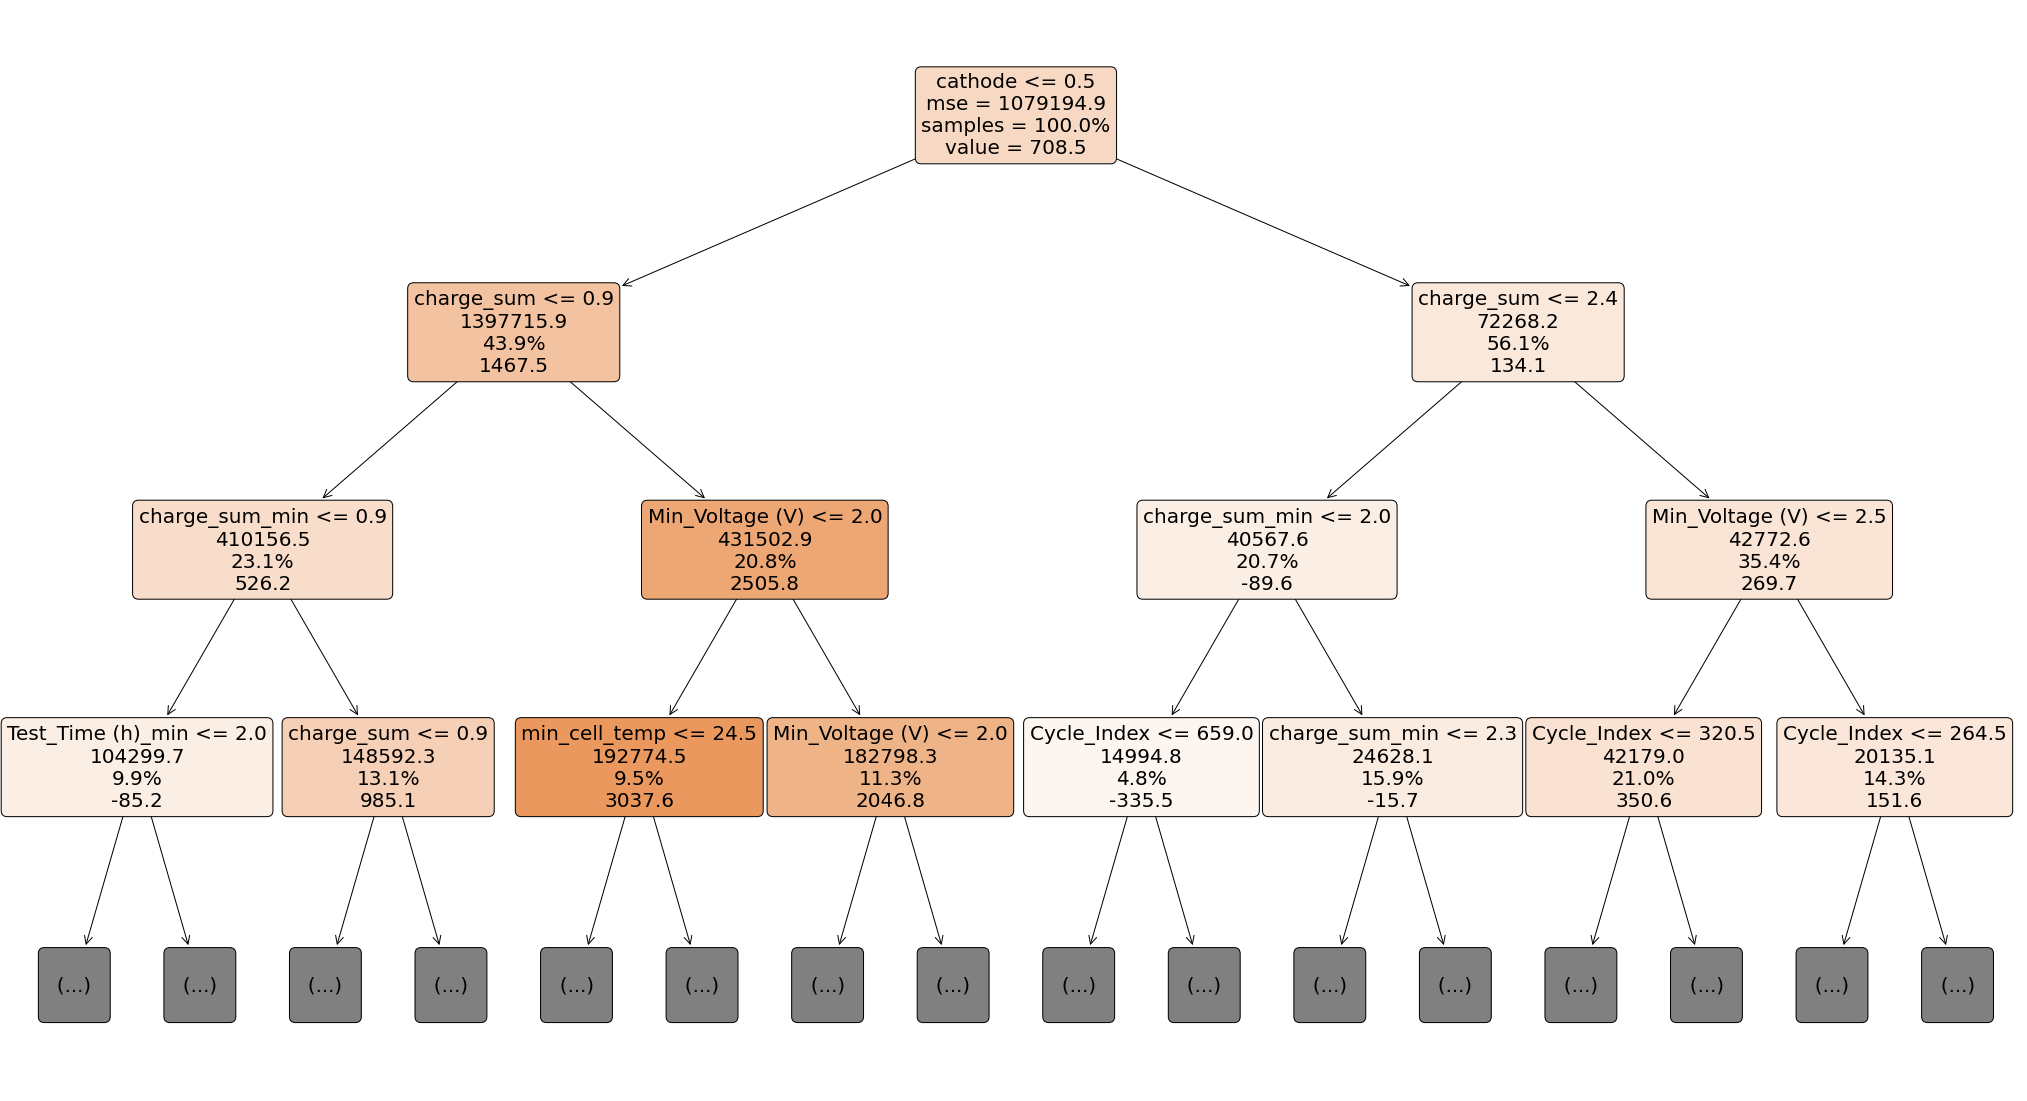

In [65]:
from sklearn import tree
fig = plt.figure(figsize=(36,20))
_ = tree.plot_tree(ens.estimators_[1],
                   max_depth = 3,
                   feature_names = tree_labels, 
                   filled = True,
                   fontsize=20,
                   rounded=True,
                   precision=1,
                   proportion=True,
                   label='root')

## Testing Data

Perform testing of the model by downloading new data from Battery Archive, cleaning and transforming it so it fits the model and predicting its RUL. This allows to judge model performance on previously unseen data from a different study.

In [8]:
def time_shift(df_data):
    #create a non-cumulative time
    df_data['seconds'] = df_data['Test_Time (s)'].shift(1)
    df_data['seconds'] = df_data['Test_Time (s)'] - df_data['seconds']
    df_data.loc[df_data['seconds'].isna() , 'seconds'] = df_data['Test_Time (s)'][0]

In [9]:
def charge_0_100(df_data, c):
    #creating a function to calculate the net capacity for batteries cycled between 0 and 100
    
    #Ccmpute the net capacity between charge and discharge capacity with minimum 0
    capacity_cycle_ah = np.array(np.maximum(df_data['Charge_Capacity (Ah)'] - df_data['Discharge_Capacity (Ah)'], 0))
    capacity_cycle_ah = np.minimum(capacity_cycle_ah, c)
    df_data['charge_sum'] = capacity_cycle_ah

In [10]:
#loading random testing data from battery archive
ul_cycle = pd.read_csv('UL-PUR_R20-OV1_18650_NCA_23C_2.5-96.5_0.5-0.5C_a_cycle_data.csv')
ul_timeseries = pd.read_csv('UL-PUR_R20-OV1_18650_NCA_23C_2.5-96.5_0.5-0.5C_a_timeseries.csv')
#set Environment_Temperature equal to Cell_Temperature as Environment_Temperature is missing
ul_timeseries['Environment_Temperature (C)'] = ul_timeseries['Cell_Temperature (C)']

In [11]:
#no missing values
print(ul_cycle.isnull().values.any())
print()
print(ul_timeseries.isnull().values.any())

False

False


In [12]:
#calculating charge_sum for timeseries data
charge_0_100(ul_timeseries, c=3.4)

#assign right charge_sum values to cycle_data
for j in ul_timeseries.groupby(by='Cycle_Index')['charge_sum'].max().index:
    ul_cycle.loc[ul_cycle['Cycle_Index'] == j, 'charge_sum'] = ul_timeseries.groupby(by='Cycle_Index')['charge_sum'].max()[j] 

In [17]:
#calculate the SOH and drop duplicates
soh(ul_cycle)
ul_timeseries.drop_duplicates(inplace=True)

In [18]:
#transform test time
time_shift(ul_cycle)
ul_cycle['seconds'] = ul_cycle['seconds']/3600
ul_cycle.rename(columns={'seconds': 'Test_Time (h)'}, inplace=True)
ul_cycle.drop('Test_Time (s)', axis=1, inplace=True)

In [19]:
#calculate the min and max cell and environment temperatures
ul_cycle['min_env_temp'] = np.array(ul_timeseries.groupby('Cycle_Index')['Environment_Temperature (C)'].min()[list(ul_cycle['Cycle_Index'])])
ul_cycle['max_env_temp'] = np.array(ul_timeseries.groupby('Cycle_Index')['Environment_Temperature (C)'].max()[list(ul_cycle['Cycle_Index'])])
ul_cycle['min_cell_temp'] = np.array(ul_timeseries.groupby('Cycle_Index')['Cell_Temperature (C)'].min()[list(ul_cycle['Cycle_Index'])])
ul_cycle['max_cell_temp'] = np.array(ul_timeseries.groupby('Cycle_Index')['Cell_Temperature (C)'].max()[list(ul_cycle['Cycle_Index'])])

In [20]:
#remove outliers
ul_cycle.drop(ul_cycle[(ul_cycle['SOH'] - ul_cycle['SOH'].shift(1).fillna(1))<-0.1].index, inplace=True)
ul_cycle.drop(ul_cycle[ul_cycle['SOH']<0.68].index, inplace=True)
ul_cycle.reset_index(drop=True, inplace=True)

<Figure size 720x720 with 0 Axes>

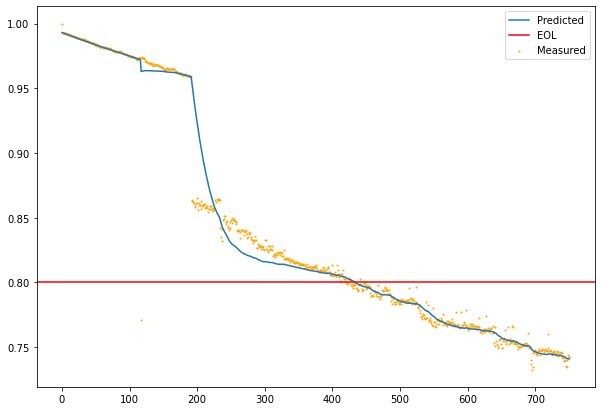

<Figure size 720x720 with 0 Axes>

In [23]:
#Apply the KF to get the predicted SOH values.
X = ul_cycle.copy()
y_measured=X['SOH']

P = np.diag([1, 20])
batt_kf = BatteryCapacityKalmanFilter(
    X=X[['Min_Current (A)', 'Max_Voltage (V)']],
    y_measured=y_measured,
    P=P, R=0.0000001, Q=0.1, dt=0.001
)
x, cov = batt_kf.run()
    
#fixing starting issues of KF
def model(x, m, n, xf, yf):
    return n*(x-xf)**2+m*(x-xf)+yf
partial_model = functools.partial(model, xf=100, yf=x[100])
p0 = [x[100]/100] # Initial guess for m, as long as xf != 0
best_fit, covar = curve_fit(partial_model, np.array((range(len(x[0:100])))), x[0:100], p0=[p0, p0])
y_fit = model(np.array((range(len(x[0:100])))), best_fit[0], best_fit[1], 100, x[100])
x[:100] = y_fit[:100]

#setting max and min values for KF
x = np.minimum(x, 1)
x = np.maximum(x, 0)

#appending the predicted SOH
ul_cycle['SOH_KF'] = x
    
# Visualising the data, with measured voltage values shown in orange and the Kalman filter prediction shown in blue.
plt.figure(figsize=(10, 7))
plt.plot(x, label='Predicted')
plt.scatter(range(len(y_measured)), y_measured, label='Measured', c='orange', s=1)
plt.axhline(y=0.8 , label='EOL', c='red', linestyle='-')
plt.legend()
plt.figure(figsize=(10, 10))

In [24]:
#extract cycle_index of when cells reach their EOL
ul_cycle['EOL_Index'] = 0
ul_cycle.loc[ul_cycle['SOH_KF']<0.8, 'EOL_Index'] = 1
ul_cycle['EOL_Index'] = (ul_cycle.EOL_Index.diff(1) != 0).astype('int').cumsum()
EOL_Index = ul_cycle.groupby('EOL_Index').Cycle_Index.first()
if len(EOL_Index) > 1:
    ul_cycle['EOL_Index'] = EOL_Index.iloc[-1]
    ul_cycle['EOL_Index'] = ul_cycle['EOL_Index'] - ul_cycle['Cycle_Index']
else:
    ul_cycle['EOL_Index'] = 0
ul_cycle.rename({'EOL_Index': 'RUL'}, axis=1, inplace=True)

In [68]:
pd.options.mode.chained_assignment = None

shift = 5
w = 31
if w > 70:
    stride = 4
elif w > 30:
    stride = 2
else:
    stride = 1

#loop over dataset of cells which reached their EOL
#drop unnecessary variables and order dataframe columns
ul_cycle = ul_cycle[['Cycle_Index', 'RUL', 'charge_sum', 
                'Test_Time (h)', 'Min_Current (A)', 'Max_Current (A)', 'Min_Voltage (V)', 
                'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 'min_cell_temp', 'max_cell_temp']]

#loop over dataframe with window size 20/w
EOL0 = ul_cycle[ul_cycle['RUL']==0].index[0]
for l in range((EOL0 - math.floor(EOL0/w)*w)+w, len(ul_cycle), shift):
    #loop over columns to be shifted in dataframe
    for j in ['Test_Time (h)', 'charge_sum', 'Min_Current (A)', 
              'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 
              'min_cell_temp', 'max_cell_temp']:
        #set slice of column and window 20/w
        current_slice = np.array(ul_cycle[j])[(l-(w-1)):l+1:stride]

        #loop over window to assign new column names and respective shifted value
        if j in ['Test_Time (h)']:
            ul_cycle.loc[ul_cycle.index == l, j + '_mean'] = current_slice.mean()
            ul_cycle.loc[ul_cycle.index == l, j + '_max'] = current_slice.max()
            ul_cycle.loc[ul_cycle.index == l, j + '_min'] = current_slice.min()
        elif j in ['Min_Current (A)', 'Min_Voltage (V)', 'min_env_temp', 'min_cell_temp']:
            ul_cycle.loc[ul_cycle.index == l, j + '_min'] = current_slice.min()
        elif j in ['Max_Current (A)', 'Max_Voltage (V)', 'max_env_temp', 'max_cell_temp']:
            ul_cycle.loc[ul_cycle.index == l, j + '_max'] = current_slice.max()
        elif j in ['charge_sum']:
            ul_cycle.loc[ul_cycle.index == l, j + '_mean'] = current_slice.mean()
            ul_cycle.loc[ul_cycle.index == l, j + '_max'] = current_slice.max()
            ul_cycle.loc[ul_cycle.index == l, j + '_min'] = current_slice.min()
            ul_cycle.loc[ul_cycle.index == l, j + '_var'] = current_slice.var()
            ul_cycle.loc[ul_cycle.index == l, j + '_skew'] = skew(current_slice)
            ul_cycle.loc[ul_cycle.index == l, j + '_kur'] = kurtosis(current_slice)
            ul_cycle.loc[ul_cycle.index == l, j + '_max_diff'] = np.abs(
                current_slice.max()-ul_cycle.loc[ul_cycle.index == l]['charge_sum'])

#drop non-batched data and reset the index
ul_cycle = ul_cycle.iloc[range((EOL0 - math.floor(EOL0/w)*w)+w, len(ul_cycle), shift)]
ul_cycle.reset_index(drop=True, inplace=True)
ul_cycle.drop(['Test_Time (h)', 'Min_Current (A)', 
              'Max_Current (A)', 'Min_Voltage (V)', 'Max_Voltage (V)', 'min_env_temp', 'max_env_temp', 
              'min_cell_temp', 'max_cell_temp'], axis=1, inplace=True)

pd.options.mode.chained_assignment = 'warn'

In [ ]:
#Save the data
ul_cycle.to_pickle('Pandas Pickle Data/ul_cycle.pkl')

When applying the model to a whole new dataset which was cycled under completely other conditions, the model still performs quite well. The RMSE is 93, the MAE is 77, the percentage error is 0.03 and the R^2 is 82%.

RandomForestClassifier testing MSE: 8626.665396
RandomForestClassifier testing MAE: 77.055972
RandomForestClassifier testing RMSE: 92.879844
RandomForestClassifier testing PE: 0.123675
RandomForestClassifier testing R^2: 0.818890


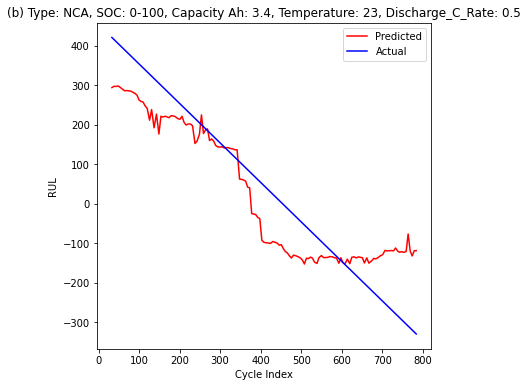

In [53]:
#read the data
ul_cycle = pd.read_pickle('Pandas Pickle Data/ul_cycle.pkl')
ul_cycle['cathode'] = 1
ul_cycle['RUL_pred'] = ens.predict(ul_cycle[x_data.columns])
print("RandomForestClassifier testing MSE: {:.6f}".format(mean_squared_error(ul_cycle['RUL_pred'], ul_cycle['RUL'])))
print("RandomForestClassifier testing MAE: {:.6f}".format(mean_absolute_error(ul_cycle['RUL_pred'], ul_cycle['RUL'])))
print("RandomForestClassifier testing RMSE: {:.6f}".format(np.sqrt(mean_squared_error(ul_cycle['RUL_pred'], ul_cycle['RUL']))))
print("RandomForestClassifier testing PE: {:.6f}".format(np.sqrt(mean_squared_error(ul_cycle['RUL_pred'], ul_cycle['RUL']))/(ul_cycle['RUL'].max()-ul_cycle['RUL'].min())))
print("RandomForestClassifier testing R^2: {:.6f}".format(ens.score(ul_cycle[x_data.columns], ul_cycle['RUL'])))
plt.figure(figsize=(6,6))
plt.xlabel('Cycle Index')
plt.ylabel('RUL')
plt.plot(ul_cycle['Cycle_Index'], ul_cycle['RUL_pred'], color='red', label='Predicted')
plt.plot(ul_cycle['Cycle_Index'], ul_cycle['RUL'], color='blue', label='Actual')
plt.title('(b) Type: NCA, SOC: 0-100, Capacity Ah: 3.4, Temperature: 23, Discharge_C_Rate: 0.5')
plt.legend()

# Early Prediction

In [80]:
ul_cycle['RUL_error'] = ul_cycle['RUL'] - ul_cycle['RUL_pred']
ul_cycle[['Cycle_Index', 'RUL', 'RUL_pred', 'RUL_error']].head(10)

Cycle_Index    RUL    RUL_pred   RUL_error
0         33.0  421.0  294.017102  126.982898
1         38.0  416.0  297.195773  118.804227
2         43.0  411.0  296.967995  114.032005
3         49.0  405.0  298.060640  106.939360
4         55.0  399.0  293.427181  105.572819
5         60.0  394.0  289.208759  104.791241
6         65.0  389.0  285.767092  103.232908
7         70.0  384.0  286.563603   97.436397
8         75.0  379.0  285.876566   93.123434
9         80.0  374.0  284.957386   89.042614

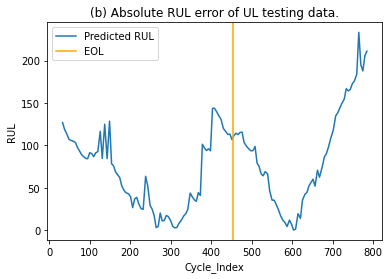

In [51]:
plt.plot(ul_cycle['Cycle_Index'], np.abs(ul_cycle['RUL_error']), label='Predicted RUL')
plt.xlabel('Cycle_Index')
plt.ylabel('RUL')
plt.axvline(x=454, c='orange', label='EOL')
plt.title('(b) Absolute RUL error of UL testing data.')
plt.legend()

In [307]:
#Early stage prediction of training data using first 100 Cycles
plot_data = x_data[x_data['Cycle_Index']<=100]
print("RandomForestClassifier testing MSE: {:.6f}".format(mean_squared_error(ens.predict(plot_data), y_data[plot_data.index])))
print("RandomForestClassifier testing MAE: {:.6f}".format(mean_absolute_error(ens.predict(plot_data), y_data[plot_data.index])))
print("RandomForestClassifier testing RMSE: {:.6f}".format(np.sqrt(mean_squared_error(ens.predict(plot_data), y_data[plot_data.index]))))
print("RandomForestClassifier testing PE: {:.6f}".format(np.sqrt(mean_squared_error(ens.predict(plot_data), y_data[plot_data.index]))/(y_data[plot_data.index].max()-y_data[plot_data.index].min())))

RandomForestClassifier testing MSE: 187.515017
RandomForestClassifier testing MAE: 6.905613
RandomForestClassifier testing RMSE: 13.693612
RandomForestClassifier testing PE: 0.003564


In [308]:
#Early stage prediction of validation data using first 100 Cycles
plot_data = val[val['Cycle_Index']<=100]
print("RandomForestClassifier testing MSE: {:.6f}".format(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL'])))
print("RandomForestClassifier testing MAE: {:.6f}".format(mean_absolute_error(plot_data['RUL_pred'], plot_data['RUL'])))
print("RandomForestClassifier testing RMSE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL']))))
print("RandomForestClassifier testing PE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL']))/(plot_data['RUL'].max()-plot_data['RUL'].min())))

RandomForestClassifier testing MSE: 4513.030744
RandomForestClassifier testing MAE: 43.197041
RandomForestClassifier testing RMSE: 67.179095
RandomForestClassifier testing PE: 0.019870


In [309]:
#Early stage prediction of testing data using first 100 Cycles
plot_data = ul_cycle[ul_cycle['Cycle_Index']<=100]
print("RandomForestClassifier testing MSE: {:.6f}".format(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL'])))
print("RandomForestClassifier testing MAE: {:.6f}".format(mean_absolute_error(plot_data['RUL_pred'], plot_data['RUL'])))
print("RandomForestClassifier testing RMSE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL']))))
print("RandomForestClassifier testing PE: {:.6f}".format(np.sqrt(mean_squared_error(plot_data['RUL_pred'], plot_data['RUL']))/(plot_data['RUL'].max()-plot_data['RUL'].min())))

RandomForestClassifier testing MSE: 10263.020249
RandomForestClassifier testing MAE: 100.493648
RandomForestClassifier testing RMSE: 101.306566
RandomForestClassifier testing PE: 1.512038


# Interpretation

Plotting the PDPs for all cells which reached their EOL.

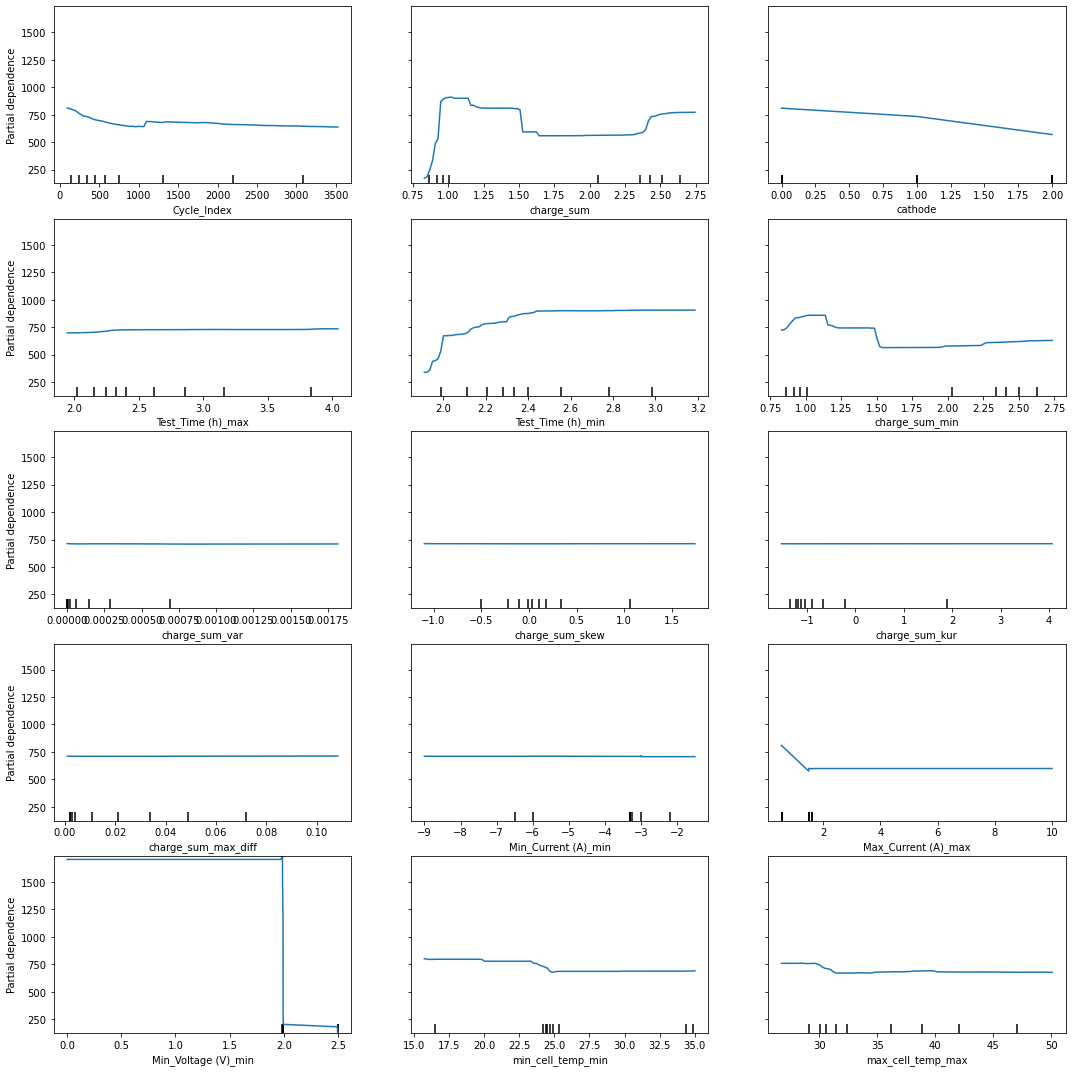

In [57]:
from sklearn.inspection import plot_partial_dependence

features = list(range(0, len(labels)))
fig, ax = plt.subplots(1, 1)
pdp = plot_partial_dependence(ens, cycle_data_EOL[x_data.columns], features, feature_names=labels, target='RUL', n_jobs=4, ax=ax) 
fig.set_figwidth(15)
fig.set_figheight(15)
fig.tight_layout()

Plotting the PDPs for NCA cells specifically.

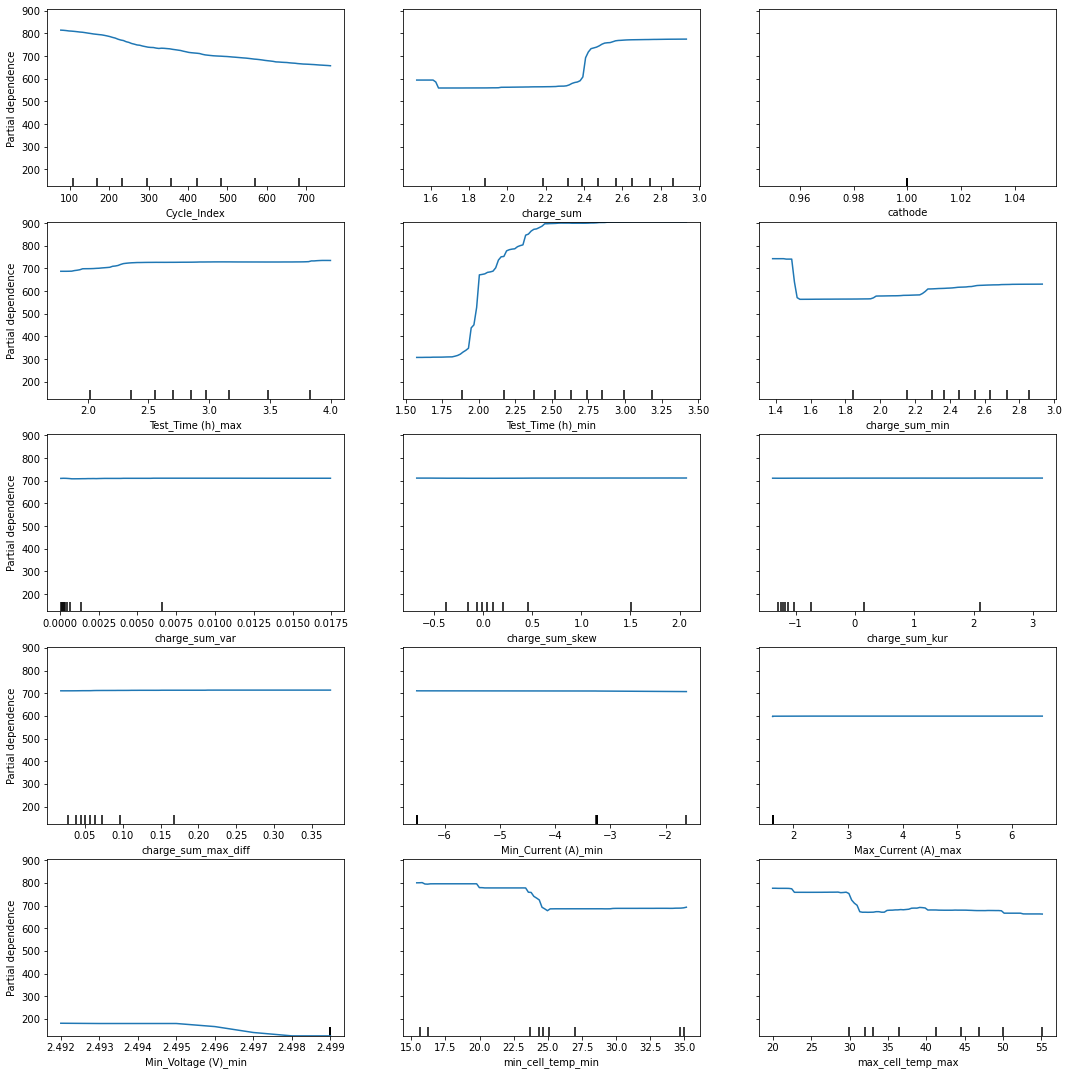

In [391]:
from sklearn.inspection import plot_partial_dependence

features = list(range(0, len(labels)))
fig, ax = plt.subplots(1, 1)
pdp = plot_partial_dependence(ens, cycle_data_EOL[cycle_data_EOL['cathode']==1][x_data.columns], features, feature_names=labels, target='RUL', n_jobs=4, ax=ax) 
fig.set_figwidth(15)
fig.set_figheight(15)
fig.tight_layout()

Adding validation and testing cells together into 1 dataset to see at which point the predicted RUL has to be so the actual RUL is still positive. For predictive maintenance we want to find the point at which the battery has to be replaced (based on the predicted RUL) but the actual RUL should still be positive, so it is still safe to use. The cycle needs to be found where the predicted RUL dips below a certain value at which point the battery has to be replaced. For example, if the first prediction for each cell which is below 66 cycles is taken as the point at which cells need to be replaced, no cell reaches their actual EOL yet. 
Use of 99.8% CI for a small sample i.e. n<30 (only 10 cells) so t disrtibution is used instead of normal distribution.

In [265]:
ul_cycle['cell_id'] = 86
l = list(x_data.columns)
l.append('cell_id')
l.append('RUL')
all_cycle = val_data[l].append(ul_cycle[l])
#all_cycle = all_cycle.append(train_data[l])
all_cycle.sort_values(by=['cell_id', 'Cycle_Index'], inplace=True)
all_cycle.reset_index(drop=True, inplace=True)
all_cycle['RUL_pred'] = ens.predict(all_cycle.drop(['cell_id', 'RUL'], axis=1))
all_cycle0 = all_cycle[all_cycle['RUL_pred']<=89]
all_cycle0 = all_cycle0.groupby("cell_id").first()[['Cycle_Index', 'RUL', 'RUL_pred']]
all_cycle0

Cycle_Index    RUL   RUL_pred
cell_id                               
12            3173.0  295.0 -37.779881
33             228.0   81.0  88.986003
34             268.0  116.0  82.364068
36             375.0   80.0  82.912118
52             202.0   75.0  87.279127
57              76.0   58.0  76.526899
59             495.0   15.0  78.256885
68             631.0   66.0  80.657566
85             581.0  142.0  85.477316
86             348.0  106.0  62.274923

Only taking the lower end of the 99.8% two-sided confidence interval, leads to a 99.9% one-sided confidence interval.

In [262]:
df = pd.DataFrame(columns=['RUL Predicted Threshold', '% Cells with RUL below 0', str(0.999*100) + '%th CI RUL lower'])
for i in range(85,96):
    all_cycle0 = all_cycle[all_cycle['RUL_pred']<=i]
    all_cycle0 = all_cycle0.groupby("cell_id").first()[['Cycle_Index', 'RUL', 'RUL_pred']]
    df.loc[i] = [i, 
                 len(all_cycle0[all_cycle0['RUL']<0])/len(all_cycle0),
                 st.t.interval(alpha=0.998, df=len(all_cycle0['RUL'])-1,
                               loc=np.mean(all_cycle0['RUL']), 
                               scale=st.sem(all_cycle0['RUL']))[0]]
df

RUL Predicted Threshold  % Cells with RUL below 0  99.9%th CI RUL lower
85                     85.0                       0.0             -2.668863
86                     86.0                       0.0             -2.547970
87                     87.0                       0.0             -0.926438
88                     88.0                       0.0             -0.126712
89                     89.0                       0.0              0.618987
90                     90.0                       0.0              0.970900
91                     91.0                       0.0              0.970900
92                     92.0                       0.0              1.789695
93                     93.0                       0.0              3.516439
94                     94.0                       0.0              3.516439
95                     95.0                       0.0              3.516439